In [2]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

dask.config.set(malloc_hook='jemalloc')

# FIXIT: Jupyter Lab scheduler view for Dask not working
client = distributed.Client()
client

2025-07-09 10:54:01,372 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6z/tqg0lf9108s22svs6qbs4d_80131yc/T/dask-worker-space/worker-hf9_a8iq', purging
2025-07-09 10:54:01,374 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6z/tqg0lf9108s22svs6qbs4d_80131yc/T/dask-worker-space/worker-hqmkqrpz', purging
2025-07-09 10:54:01,378 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6z/tqg0lf9108s22svs6qbs4d_80131yc/T/dask-worker-space/worker-rkzub478', purging
2025-07-09 10:54:01,379 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6z/tqg0lf9108s22svs6qbs4d_80131yc/T/dask-worker-space/worker-4p4enyaz', purging
2025-07-09 10:54:01,380 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/6z/tqg0lf9108s22svs6qbs4d_80131yc/T/dask-worker-space/worker-jp5u9xsd', purging


<Client: 'tcp://127.0.0.1:50622' processes=5 threads=10, memory=16.00 GiB>

# Read dataset

In [3]:
# File path directories

# inDirName = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Get full path of the aislens_emulation directory. All file IO is relative to this path.
main_dir = Path.cwd().parent
#dir_ext_data = 'data/external/'
#dir_interim_data = 'data/interim/'
DIR_external = 'data/external/'
DIR_processed = 'data/processed/'
FILE_MeltDraftObs = 'ANT_G1920V01_IceShelfMeltDraft.nc'
FILE_basalMeltObs_deSeasonalized = 'obs23_melt_anm.nc'
FILE_iceShelvesShape = 'iceShelves.geojson'

ICESHELVES_MASK = gpd.read_file(main_dir / DIR_external / FILE_iceShelvesShape)
icems = ICESHELVES_MASK.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

obs23_melt_detrend_uniform_deseasonalize_uniform = xr.open_dataset(main_dir / DIR_processed / "obs23_melt_detrend_uniform_deseasonalize_uniform.nc", chunks={"x":729, "y":729})

MELTDRAFT_OBS = xr.open_dataset(main_dir / DIR_external / FILE_MeltDraftObs, chunks={"x":729, "y":729})
# MELTDRAFT_OBS = xr.open_dataset(main_dir / DIR_external / FILE_MeltDraftObs)
obs23_melt = MELTDRAFT_OBS.melt
obs23_draft = MELTDRAFT_OBS.draft

# Time series of spatial mean melt
obs23_melt_ts = obs23_melt.mean(dim=['x', 'y']).compute()

# Time mean of melt rate and draft
obs23_melt_tm = obs23_melt.mean(dim='time').compute()
obs23_draft_tm = obs23_draft.mean(dim='time').compute()

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


FileNotFoundError: [Errno 2] No such file or directory: b'/Users/smurugan9/research/aislens/AISLENS/data/processed/obs23_melt_detrend_uniform_deseasonalize_uniform.nc'

In [4]:
obs23_prepared = xr.open_dataset(main_dir / DIR_processed / "satellite_observations_prepared.nc", chunks={"x":729, "y":729})

In [5]:
obs23_prepared_mean = obs23_prepared.mean(dim='Time').compute()

In [6]:
for i, value in enumerate(icems.name.values):
    print(i, value)

0 Filchner-Ronne
1 Ross
2 Antarctica
3 Peninsula
4 West Antarctica
5 East Antarctica
6 IMBIE1
7 IMBIE2
8 IMBIE3
9 IMBIE4
10 IMBIE5
11 IMBIE6
12 IMBIE7
13 IMBIE8
14 IMBIE9
15 IMBIE10
16 IMBIE11
17 IMBIE12
18 IMBIE13
19 IMBIE14
20 IMBIE15
21 IMBIE16
22 IMBIE17
23 IMBIE18
24 IMBIE19
25 IMBIE20
26 IMBIE21
27 IMBIE22
28 IMBIE23
29 IMBIE24
30 IMBIE25
31 IMBIE26
32 IMBIE27
33 Abbot
34 Amery
35 Atka
36 Aviator
37 Bach
38 Baudouin
39 Borchgrevink
40 Brahms
41 Brunt_Stancomb
42 Campbell
43 Cheetham
44 Conger_Glenzer
45 Cook
46 Cosgrove
47 Crosson
48 Dennistoun
49 Dibble
50 Dotson
51 Drygalski
52 Edward_VIII
53 Ekstrom
54 Ferrigno
55 Filchner
56 Fimbul
57 Fitzgerald
58 Frost
59 GeikieInlet
60 George_VI
61 Getz
62 Gillet
63 Hamilton
64 Hannan
65 HarbordGlacier
66 Helen
67 Holmes
68 HolmesWest
69 Hull
70 Jelbart
71 Land
72 Larsen_B
73 Larsen_C
74 Larsen_D
75 Larsen_E
76 Larsen_F
77 Larsen_G
78 Lazarev
79 Lillie
80 Mariner
81 Matusevitch
82 Mendelssohn
83 Mertz
84 Moscow_University
85 Moubray
86 Mul

In [7]:
# Clip the data in obs23_prepared_mean to different ice shelf regions as defined in icems and plot a scatter plot of the melt vs draft
from aislens.geospatial import clip_data
from aislens.utils import write_crs

obs23_prepared_mean = write_crs(obs23_prepared_mean)
obs23_prepared_mean_clipped = clip_data(obs23_prepared_mean, 55, icems)

#np.nanquantile(obs23_prepared_mean_clipped.melt, 0.01)
#np.nanquantile(obs23_prepared_mean_clipped.melt, 0.99)
#np.nanquantile(obs23_prepared_mean_clipped.draft, 0.01)
#np.nanquantile(obs23_prepared_mean_clipped.draft, 0.99)

# Calculate the above melt and draft quantiles, and filter the data in obs23_prepared_mean_clipped.melt and obs23_prepared_mean_clipped.draft respectively to 
# only include the data within the quantiles
melt_quantiles = obs23_prepared_mean_clipped.melt.quantile([0.01, 0.99]).compute()
draft_quantiles = obs23_prepared_mean_clipped.draft.quantile([0.01, 0.99]).compute()

obs23_prepared_mean_clipped_filtered = obs23_prepared_mean_clipped.where(
    (obs23_prepared_mean_clipped.melt >= melt_quantiles[0]) &
    (obs23_prepared_mean_clipped.melt <= melt_quantiles[1]) &
    (obs23_prepared_mean_clipped.draft >= draft_quantiles[0]) &
    (obs23_prepared_mean_clipped.draft <= draft_quantiles[1]),
    drop=True
)


In [79]:
# filter the full dataset based on quantiles before clipping
melt_quantiles = obs23_prepared_mean.melt.quantile([0.01, 0.99]).compute()
draft_quantiles = obs23_prepared_mean.draft.quantile([0.01, 0.99]).compute()

obs23_prepared_mean_filtered = obs23_prepared_mean.where(
    (obs23_prepared_mean.melt >= melt_quantiles[0]) &
    (obs23_prepared_mean.melt <= melt_quantiles[1]) &
    (obs23_prepared_mean.draft >= draft_quantiles[0]) &
    (obs23_prepared_mean.draft <= draft_quantiles[1]),
    drop=True
)

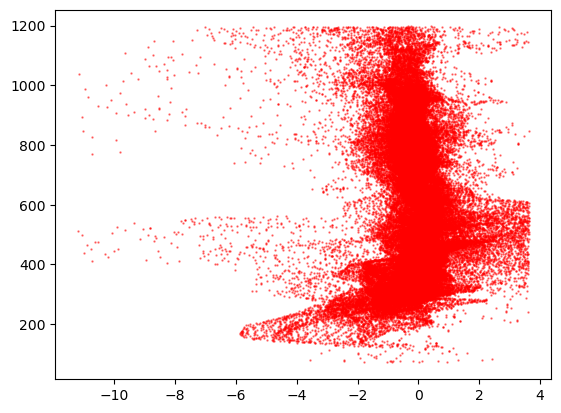

In [84]:
obs23_prepared_mean_region = clip_data(obs23_prepared_mean_filtered, 0, icems)

plt.scatter(obs23_prepared_mean_region.melt, obs23_prepared_mean_region.draft, s=0.5, c='r', alpha=0.5)

In [90]:
obs23_prepared_mean_clipped

<xarray.Dataset>
Dimensions:      (x: 1348, y: 964)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -1.681e+06 -1.679e+06 ... 9.034e+05 9.053e+05
  * y            (y) float64 1.654e+06 1.652e+06 ... -1.93e+05 -1.949e+05
Data variables:
    mapping      float64 0.0
    melt         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    draft        (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [112]:
obs23_prepared_mean_clipped_filtered.melt.std()

<xarray.DataArray 'melt' ()>
array(0.99658546)
Coordinates:
    spatial_ref  int64 0

In [134]:
plt.figure(figsize=(15, 15))
plt.scatter(obs23_prepared_mean_clipped.melt, obs23_prepared_mean_clipped.draft, s=0.85, c='r', alpha=0.85, label='All Data')
plt.scatter(obs23_prepared_mean_clipped_filtered.melt, obs23_prepared_mean_clipped_filtered.draft, s=0.25, c='k', alpha=0.5, label='Filtered Data (98% Quantiles)')
plt.axhline(draft_quantiles[1], color='k', linestyle='--', linewidth=0.5, label='Draft 99% Quantile')
# Reverse the y axis to have 0 at the top
plt.gca().invert_yaxis()
plt.legend()

Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2025-07-08 12:58:51,002 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-07-08 12:58:51,002 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-07-08 12:58:51,002 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-07-08 12:58:50,999 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-07-08 12:58:51,003 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/smurugan9/o

Error in callback <function flush_figures at 0x1a72d6050> (for post_execute):


KeyboardInterrupt: 

In [107]:
def plot_ice_shelf_melt_vs_draft(obs23_prepared_mean, icems, shelf_indices, outdir="figures", quantiles=[0.01, 0.99]):
    """
    For each ice shelf index in shelf_indices, clip the data, filter by quantiles, 
    plot melt vs draft scatter, and save the figure.

    Args:
        obs23_prepared_mean (xr.Dataset): Dataset with 'melt' and 'draft'.
        icems (GeoDataFrame): Ice shelf geometries.
        shelf_indices (list): List of ice shelf indices to plot.
        outdir (str): Directory to save figures.
        quantiles (list): Quantiles for filtering, e.g., [0.01, 0.99].
    """
    import os
    import matplotlib.pyplot as plt
    from aislens.geospatial import clip_data
    from aislens.utils import write_crs

    os.makedirs(outdir, exist_ok=True)
    obs23_prepared_mean = write_crs(obs23_prepared_mean)

    for i in shelf_indices:
        obs23_prepared_mean_clipped = clip_data(obs23_prepared_mean, i, icems)

        # Compute quantiles for melt and draft
        melt_quantiles = obs23_prepared_mean_clipped.melt.quantile(quantiles).compute()
        draft_quantiles = obs23_prepared_mean_clipped.draft.quantile(quantiles).compute()

        # Filter data within quantiles
        filtered = obs23_prepared_mean_clipped.where(
            (obs23_prepared_mean_clipped.melt >= melt_quantiles[0]) &
            (obs23_prepared_mean_clipped.melt <= melt_quantiles[1]) &
            (obs23_prepared_mean_clipped.draft >= draft_quantiles[0]) &
            (obs23_prepared_mean_clipped.draft <= draft_quantiles[1]),
            drop=True
        )

        plt.figure(figsize=(15, 15))
        plt.scatter(obs23_prepared_mean_clipped.melt, obs23_prepared_mean_clipped.draft, 
                    s=0.85, c='r', alpha=0.85, label='All Data')
        plt.scatter(filtered.melt, filtered.draft, 
                    s=0.25, c='k', alpha=0.5, label=f'Filtered Data ({int((quantiles[1]-quantiles[0])*100)}% Quantiles)')
        plt.axhline(draft_quantiles[1], color='k', linestyle='--', linewidth=0.5, label=f'Draft {int(quantiles[1]*100)}% Quantile')
        plt.gca().invert_yaxis()
        plt.xlabel('Basal Melt Rate (m/yr)')
        plt.ylabel('Ice Draft (m)')
        plt.title(f'Melt vs Draft for {icems.name.values[i]}')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, f"{icems.name.values[i]}_melt_vs_draft.png"))
        plt.close()

In [108]:
plot_ice_shelf_melt_vs_draft(obs23_prepared_mean, icems, shelf_indices=range(len(icems)), outdir="/Users/smurugan9/research/aislens/AISLENS/data/figures/Paolo23")

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


In [ ]:
def plot_melt_std_all_vs_filtered(obs23_prepared_mean, icems, shelf_indices=None, quantiles=[0.01, 0.99], outdir=None):
    """
    For each ice shelf, clip and quantile-filter the data, calculate the std of melt
    for both all data and filtered data, and plot a grouped bar chart.

    Args:
        obs23_prepared_mean (xr.Dataset): Dataset with 'melt' and 'draft'.
        icems (GeoDataFrame): Ice shelf geometries.
        shelf_indices (list or None): List of ice shelf indices to process. If None, use all.
        quantiles (list): Quantiles for filtering, e.g., [0.01, 0.99].
        outdir (str or None): If given, save the plot to this directory.
    """
    import os
    import matplotlib.pyplot as plt
    from aislens.geospatial import clip_data
    from aislens.utils import write_crs

    obs23_prepared_mean = write_crs(obs23_prepared_mean)
    if shelf_indices is None:
        shelf_indices = range(len(icems))

    stds_all = []
    stds_filtered = []
    stds_diff = []
    names = []

    for i in shelf_indices:
        ds_clip = clip_data(obs23_prepared_mean, i, icems)
        melt_q = ds_clip.melt.quantile(quantiles).compute()
        draft_q = ds_clip.draft.quantile(quantiles).compute()
        ds_filt = ds_clip.where(
            (ds_clip.melt >= melt_q[0]) & (ds_clip.melt <= melt_q[1]) &
            (ds_clip.draft >= draft_q[0]) & (ds_clip.draft <= draft_q[1]),
            drop=True
        )
        std_all = float(ds_clip.melt.std().values)
        std_filt = float(ds_filt.melt.std().values)
        std_diff = std_all - std_filt
        stds_all.append(std_all)
        stds_filtered.append(std_filt)
        stds_diff.append(std_diff)
        names.append(icems.name.values[i])

    x = range(len(names))
    plt.figure(figsize=(max(12, len(names)//2), 6))
    plt.bar(x, stds_all, width=0.4, label='All Data', align='center', alpha=0.7)
    plt.bar([i + 0.4 for i in x], stds_filtered, width=0.4, label='Filtered Data', align='center', alpha=0.7)
    plt.ylabel('Melt Standard Deviation (m/yr)')
    plt.xlabel('Ice Shelf')
    plt.title('Standard Deviation of Melt (All vs. Filtered by Ice Shelf)')
    plt.xticks([i + 0.2 for i in x], names, rotation=90)
    plt.legend()
    plt.tight_layout()
    if outdir:
        os.makedirs(outdir, exist_ok=True)
        plt.savefig(os.path.join(outdir, "melt_std_all_vs_filtered_by_ice_shelf.png"))
    plt.show()

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


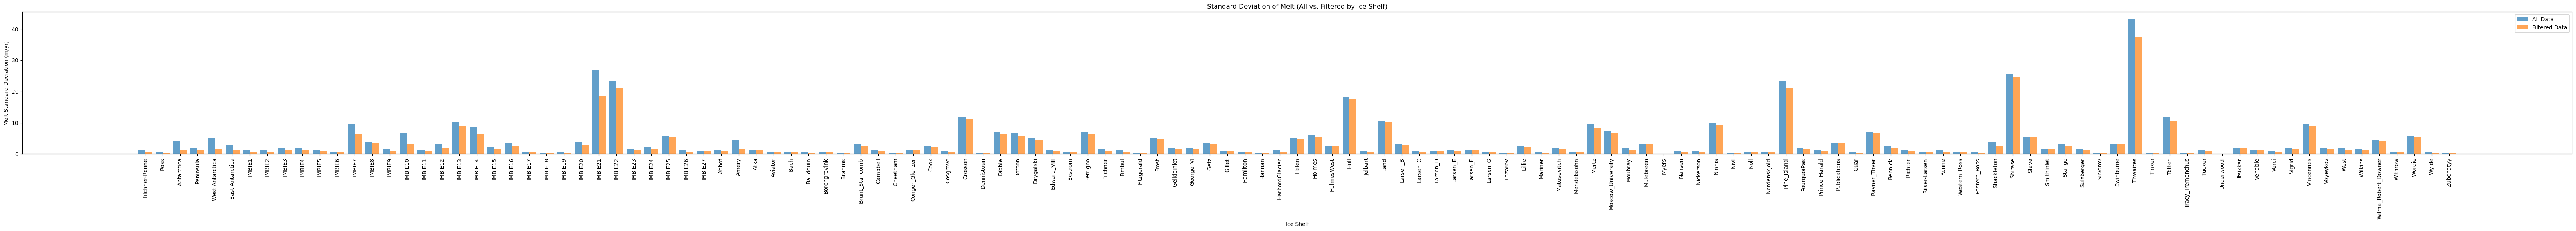

In [114]:
plot_melt_std_all_vs_filtered(obs23_prepared_mean, icems, shelf_indices=range(len(icems)), outdir="/Users/smurugan9/research/aislens/AISLENS/data/figures/Paolo23")

In [121]:
stds_all

NameError: name 'stds_all' is not defined

In [115]:
draft_dependence_params = xr.open_dataset(main_dir / DIR_processed / "draft_dependence_params.nc")

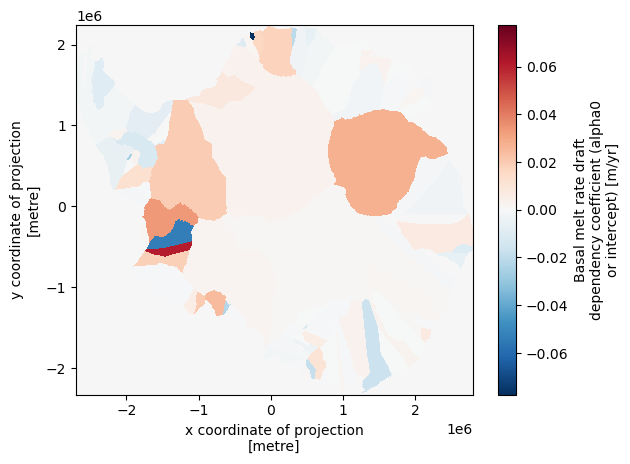

In [122]:
draft_dependence_params.draftDepenBasalMeltAlpha0.plot()

In [119]:
mali_ic = xr.open_dataset(main_dir / DIR_processed / "AIS_4to20km_r01_20220907_m5_drop_bed_20m_bulldoze_troughs_75_to_400m_Enderby_maxstiffness_0.8_TG_pinning_40maf_bedmap2_surface_ASE_05perc_seafloor_mu_meanSatObsBMB_Paolo2023_draftDepen.nc")

In [123]:
mali_ic

<xarray.Dataset>
Dimensions:                               (nEdges: 1161656, nCells: 385379,
                                           nVertices: 776277, Time: 1,
                                           maxEdges: 9, TWO: 2,
                                           vertexDegree: 3, nVertInterfaces: 6,
                                           maxEdges2: 18, nVertLevels: 5,
                                           nRegions: 16)
Dimensions without coordinates: nEdges, nCells, nVertices, Time, maxEdges, TWO,
                                vertexDegree, nVertInterfaces, maxEdges2,
                                nVertLevels, nRegions
Data variables: (12/67)
    angleEdge                             (nEdges) float64 ...
    areaCell                              (nCells) float64 ...
    areaTriangle                          (nVertices) float64 ...
    basalHeatFlux                         (Time, nCells) float64 ...
    bedTopography                         (Time, nCells) float64 ...
    bedTopographyOriginal                 (Time, nCells) float64 ...
    ...                                    ...
    yVertex                               (nVertices) float64 ...
    zCell                                 (nCells) float64 ...
    zEdge                                 (nEdges) float64 ...
    zVertex                               (nVertices) float64 ...
    draftDepenBasalMeltAlpha0             (Time, nCells) float64 ...
    draftDepenBasalMeltAlpha1             (Time, nCells) float64 ...
Attributes:
    on_a_sphere:                NO
    sphere_radius:              0.0
    is_periodic:                NO
    parent_id:                  lclrmiizwz\npmtzb5h15d\nsjrc424ult\nt28yfwmmt...
    history:                    Thu Jun 19 20:08:28 2025: interpolate_to_mpas...
    mesh_spec:                  1.0
    Conventions:                MPAS
    source:                     MpasMeshConverter.x
    file_id:                    y808v7bkix
    NCO:                        netCDF Operators version 5.1.5 (Homepage = ht...
    history_of_appended_files:  Mon Jun 24 15:36:22 2024: Appended file AIS_4...

In [124]:
ctrl_outputstate2000 = xr.open_dataset(main_dir / "data/MALI/ENSEMBLES/CTRL/EM8/output_state_2000.nc")
ctrl_outputflux2000 = xr.open_dataset(main_dir / "data/MALI/ENSEMBLES/CTRL/EM8/output_flux_all_timesteps_2000.nc")

In [127]:
ctrl_outputflux2000.floatingBasalMassBalApplied

<xarray.DataArray 'floatingBasalMassBalApplied' (Time: 4, nCells: 385379)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Dimensions without coordinates: Time, nCells
Attributes:
    units:      kg m^{-2} s^{-1}
    long_name:  Applied basal mass balance on floating regions

In [ ]:
#ctrl_outputflux2000_crs = write_crs(ctrl_outputflux2000)
#ctrl_outputflux2000_clipped = clip_data(ctrl_outputflux2000_crs, 0, icems)

MissingSpatialDimensionError: x dimension not found. 'rio.set_spatial_dims()' or using 'rename()' to change the dimension name to 'x' can address this. Data variable: damage

In [142]:
# convert ctrl_outputflux2000.floatingBasalMassBalApplied from kg m^{-2} s^{-1} to m/yr

floatingBasalMassBalApplied_myr = ctrl_outputflux2000.floatingBasalMassBalApplied * 60 * 60 * 24 * 365.25 / 1000

In [154]:
icems

name tags  object   component            author  \
0         Filchner-Ronne       region  iceshelves  Xylar Asay-Davis   
1                   Ross       region  iceshelves  Xylar Asay-Davis   
2             Antarctica       region  iceshelves  Xylar Asay-Davis   
3              Peninsula       region  iceshelves  Xylar Asay-Davis   
4        West Antarctica       region  iceshelves  Xylar Asay-Davis   
..                   ...  ...     ...         ...               ...   
128  Wilma_Robert_Downer       region  iceshelves  Xylar Asay-Davis   
129              Withrow       region  iceshelves  Xylar Asay-Davis   
130               Wordie       region  iceshelves  Xylar Asay-Davis   
131                Wylde       region  iceshelves  Xylar Asay-Davis   
132            Zubchatyy       region  iceshelves  Xylar Asay-Davis   

                                          constituents  \
0    Filchner_2; Filchner_3; Ronne_2; Filchner_1; R...   
1    Eastern_Ross_1; Western_Ross_1; Eastern_Ross_3...   
2    Cosgrove_2; Moscow_University; Edward_VIII_1; ...   
3    Stange_2; Larsen_D; Larsen_C_3; Brahms; Wilkin...   
4    Cosgrove_2; Pine_Island; Thwaites; Swinburne; ...   
..                                                 ...   
128                                Wilma_Robert_Downer   
129                                            Withrow   
130                                             Wordie   
131                                              Wylde   
132                                          Zubchatyy   

                                               history  \
0    11/18/21 12:31 : lawn-128-61-33-51.lawn.gatech...   
1    11/18/21 12:31 : lawn-128-61-33-51.lawn.gatech...   
2    11/18/21 12:31 : lawn-128-61-33-51.lawn.gatech...   
3    11/18/21 12:31 : lawn-128-61-33-51.lawn.gatech...   
4    11/18/21 12:31 : lawn-128-61-33-51.lawn.gatech...   
..                                                 ...   
128  11/18/21 12:31 : lawn-128-61-33-51.lawn.gatech...   
129  11/18/21 12:31 : lawn-128-61-33-51.lawn.gatech...   
130  11/18/21 12:31 : lawn-128-61-33-51.lawn.gatech...   
131  11/18/21 12:31 : lawn-128-61-33-51.lawn.gatech...   
132  11/18/21 12:31 : lawn-128-61-33-51.lawn.gatech...   

                                              geometry  
0    MULTIPOLYGON (((-2000.663 -189562.895, -3000.9...  
1    MULTIPOLYGON (((-140531.742 -1579356.754, -141...  
2    POLYGON ((-143032.334 -1577856.665, -143532.46...  
3    POLYGON ((-1629342.754 478600.686, -1630342.80...  
4    POLYGON ((-675711.418 -134041.937, -675711.465...  
..                                                 ...  
128  MULTIPOLYGON (((1739755.084 1180173.027, 17402...  
129  POLYGON ((-339078.855 -1496848.158, -338078.64...  
130  POLYGON ((-2113247.771 819596.080, -2112248.03...  
131  POLYGON ((418080.750 -1766841.214, 419080.929 ...  
132  POLYGON ((1878147.530 1601625.794, 1878647.337...  

[133 rows x 8 columns]

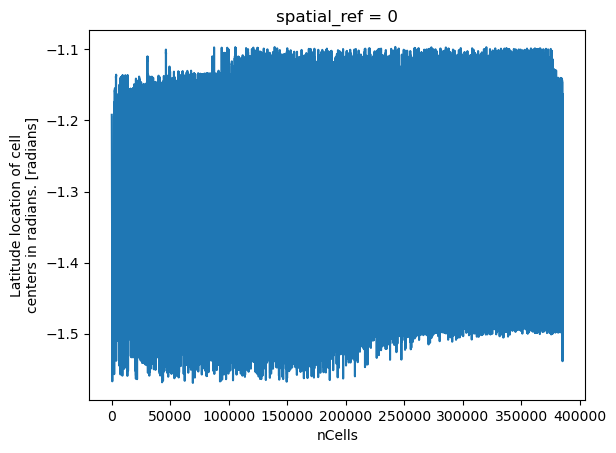

In [156]:
# Apply icems polygons to ctrl_outputflux2000 (which is on variable grid)
ctrl_outputflux2000.latCell.plot()

In [143]:
floatingBasalMassBalApplied_myr

<xarray.DataArray 'floatingBasalMassBalApplied' (Time: 4, nCells: 385379)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    spatial_ref  int64 0
Dimensions without coordinates: Time, nCells

In [ ]:
c

Data variables:
    xtime                           (Time) |S64 ...
    simulationStartTime             |S64 ...
    damage                          (Time, nCells) float64 ...
    calvingThickness                (Time, nCells) float64 ...
    calvingThicknessFromThreshold   (Time, nCells) float64 ...
    calvingVelocity                 (Time, nCells) float64 ...
    surfaceSpeed                    (Time, nCells) float64 ...
    daysSinceStart                  (Time) timedelta64[ns] ...
    cellMask                        (Time, nCells) int32 ...
    sfcMassBalApplied               (Time, nCells) float64 ...
    floatingBasalMassBalApplied     (Time, nCells) float64 0.0 0.0 ... 0.0 0.0
    groundedBasalMassBalApplied     (Time, nCells) float64 ...
    deltat                          (Time) float64 ...
    fluxAcrossGroundingLineOnCells  (Time, nCells) float64 ...
    xvelmean                        (Time, nCells) float64 ...
    yvelmean                        (Time, nCells) float64 ...

In [166]:
ctrl_outputflux2000.rio.set_spatial_dims('xCell', 'yCell', inplace=True).clip(icems.loc[[0], 'geometry'].apply(mapping), icems.crs)

MissingSpatialDimensionError: x dimension (xCell) not found.

In [159]:
def clip_data_cust(DATA, iceShelfMask_index):
    masked_data = DATA.rio.clip(icems.loc[[iceShelfMask_index],'geometry'].apply(mapping), icems.crs, drop=False)
    return masked_data

In [ ]:
clip_data_cust(ctrl_outputflux2000, 0)

rio.set_spatial_dims(
    'latCell', 'lonCell', inplace=True
)

MissingSpatialDimensionError: x dimension not found. 'rio.set_spatial_dims()' or using 'rename()' to change the dimension name to 'x' can address this. Data variable: damage

In [1]:
# plot ctrl_outputflux2000.floatingBasalMassBalApplied vs ctrl_outputstate2000.lowerSurface scatter plot
plt.figure(figsize=(15, 15))
plt.scatter(obs23_prepared_mean.melt, -obs23_prepared_mean.draft, s=0.5, c='r', alpha=0.5)
plt.scatter(floatingBasalMassBalApplied_myr[-1], ctrl_outputstate2000.lowerSurface[-1] - ctrl_outputstate2000.config_sea_level, s=0.5, c='b', alpha=0.5)
plt.xlabel('Floating Basal Mass Balance Applied (m/yr)')
plt.ylabel('Lower Surface (m)')
plt.ylim(-3500,0)
#plt.xlim(-10,10)
plt.title('Floating Basal Mass Balance vs Lower Surface (2000)')
plt.grid()
plt.tight_layout()

NameError: name 'plt' is not defined

In [177]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Get cell centers as a DataFrame
cell_df = pd.DataFrame({
    'xCell': ctrl_outputflux2000.xCell.values,
    'yCell': ctrl_outputflux2000.yCell.values,
    'latCell': ctrl_outputflux2000.latCell.values,
    'lonCell': ctrl_outputflux2000.lonCell.values
})

# Build geometry column (assuming lon/lat are in degrees)
cell_gdf = gpd.GeoDataFrame(
    cell_df,
    geometry=gpd.points_from_xy(cell_df.lonCell, cell_df.latCell),
    crs="epsg:3031"  # or the correct CRS for your data
)

# Reproject to match icems CRS if needed
cell_gdf = cell_gdf.to_crs(icems.crs)

0    MULTIPOLYGON (((-2000.663 -189562.895, -3000.9...
Name: geometry, dtype: geometry

In [178]:
# For a single ice shelf (e.g., index 0)
ice_shelf_geom = icems.loc[[0], 'geometry']

# Find points within the polygon
within_mask = cell_gdf.within(ice_shelf_geom.values[0])
selected_cells = cell_gdf[within_mask]

In [179]:
# Get indices of selected cells
cell_indices = selected_cells.index.values

# Select those cells from your data variable
masked_data = ctrl_outputflux2000.floatingBasalMassBalApplied.isel(nCells=cell_indices)

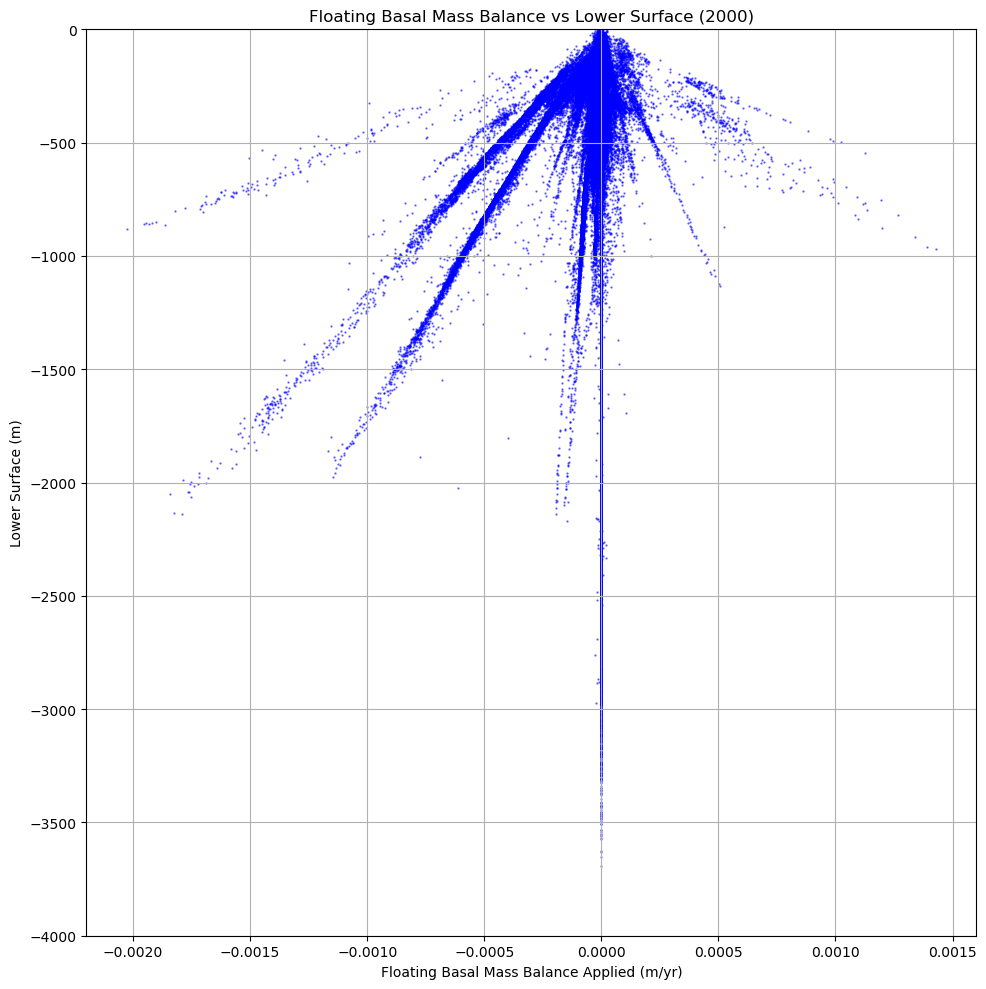

In [182]:
# plot ctrl_outputflux2000.floatingBasalMassBalApplied vs ctrl_outputstate2000.lowerSurface scatter plot
plt.figure(figsize=(10, 10))
#plt.scatter(obs23_prepared_mean.melt, -obs23_prepared_mean.draft, s=0.5, c='r', alpha=0.5)
plt.scatter(masked_data[-1], ctrl_outputstate2000.lowerSurface[-1] - ctrl_outputstate2000.config_sea_level, s=0.5, c='b', alpha=0.5)
plt.xlabel('Floating Basal Mass Balance Applied (m/yr)')
plt.ylabel('Lower Surface (m)')
plt.ylim(-4000,0)
plt.title('Floating Basal Mass Balance vs Lower Surface (2000)')
plt.grid()
plt.tight_layout()

In [78]:
# Note the colorbar extent is set to half of the max of the 1% and 99% quantiles in the raw data variable for better visualization.
obs23_melt_tm_vmin = np.nanquantile(obs23_melt_tm.values, 0.01)
obs23_melt_tm_vmax = np.nanquantile(obs23_melt_tm.values, 0.99)

# Plot figure

sns.set_theme(style="whitegrid")

plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

#icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
#icems[34:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=4)


#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)

obs23_melt_tm.plot(ax=ax1, vmin=-abs(obs23_melt_tm_vmin)/4, vmax=abs(obs23_melt_tm_vmin)/4, cmap='RdBu_r', cbar_kwargs={'label': 'Basal melt rate (m/yr)'}, zorder=5)
plt.title('Mean ice shelf basal melt rate from satellite observations (1992-2017)')

NameError: name 'obs23_melt_tm' is not defined

Text(0.5, 1.0, 'Ice draft underneath ice shelves (mean during 1992-2017)')

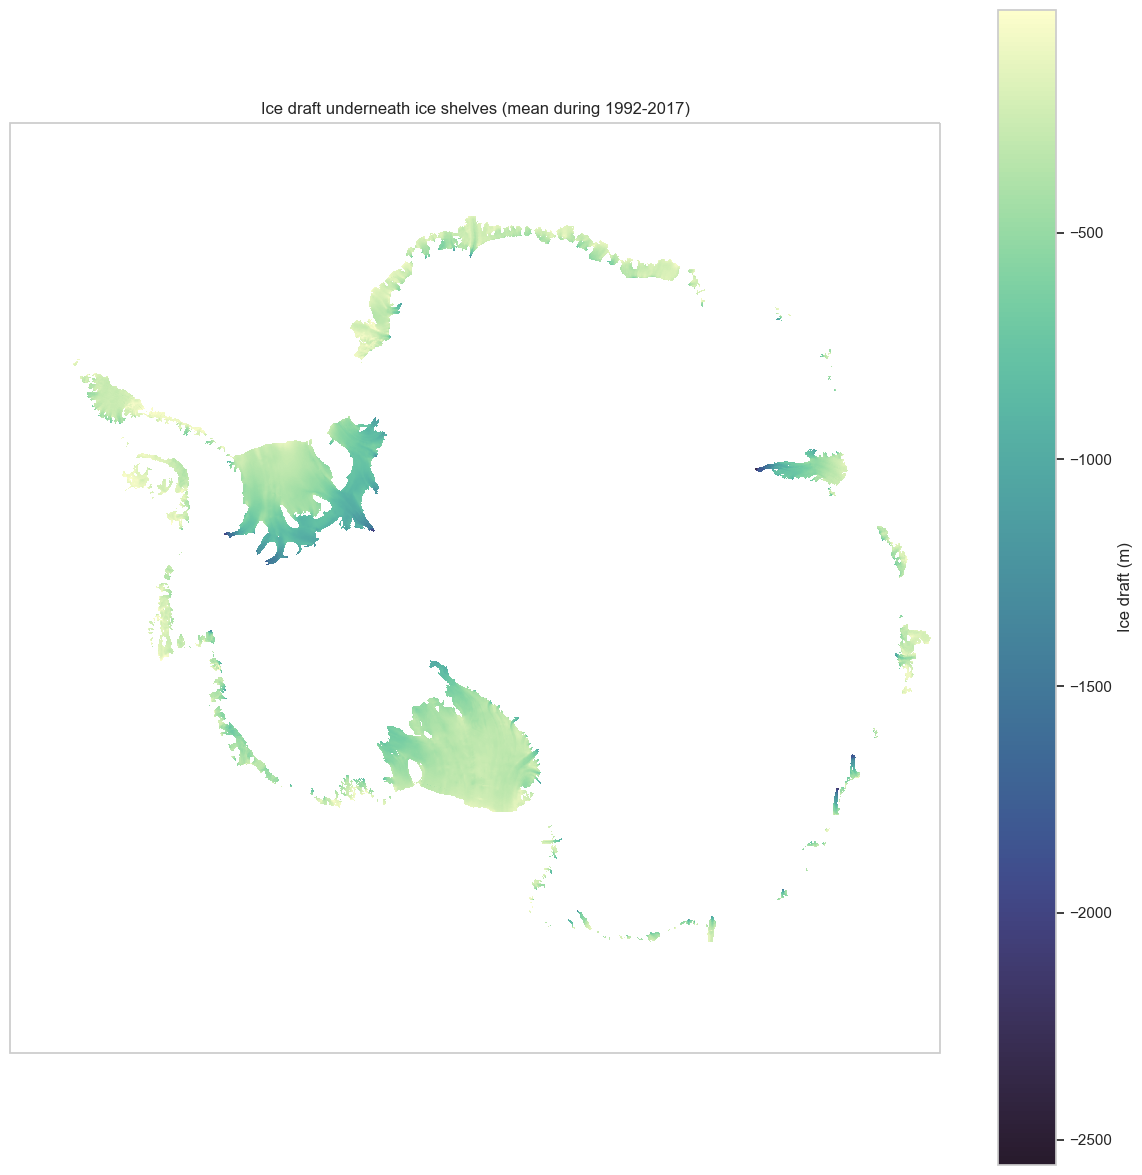

In [ ]:
# Note the colorbar extent is set to half of the max of the 1% and 99% quantiles in the raw data variable for better visualization.
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

#icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
#icems[34:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=4)


#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
# ax1.coastlines(lw=0.2)

(0-obs23_draft_tm).plot(ax=ax1, cmap=cmocean.cm.deep_r, cbar_kwargs={'label': 'Ice draft (m)'}, zorder=5)
plt.title('Ice draft underneath ice shelves (mean during 1992-2017)')

In [19]:
obs23_melt_detrend_uniform_deseasonalize_uniform_ts = obs23_melt_detrend_uniform_deseasonalize_uniform.melt.mean(['x','y']).compute()

2024-06-11 18:31:28,446 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 17 MB fds: 36>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/system_monitor.py", line 134, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory
2024-06-11 18:31:28,446 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 17 MB fds: 36>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/s

## Detrend dataset

The satellite observational dataset of basal melt rate is fit to a linear polynomial function to remove any inherent trend.

Interestingly, there is a bump in the linear trend in 2012 that should be explained, using Method 1 (naive).

The methodology for detrending has been tested/verified to be correct.

### Method 1 (*Per-pixel*)
Detrend the time series of spatial mean melt rate using a linear trend that is unique at each spatial point.

A first order polynomial fit is performed **on the raw 3 dimensional dataset** and this fit is subtracted from all pixel locations in the data.


### Method 2 (*Uniform*)
Detrend the time series of spatial mean melt rate using a mean linear trend that is uniform at all spatial points.

A first order polynomial fit (linear decomposition) is performed **on the spatially averaged dataset** (i.e., essentially a time series data), and this same fit is subtracted from all locations in the data.

In [23]:
def detrend_dim(data, dim, deg):
    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    return data - fit

#### Detrend Method 1 (per-pixel)

In [6]:
# Method 1: Detrend the time series of spatial mean melt rate using a linear trend that is unique at each spatial point
obs23_melt_detrend_perpixel = detrend_dim(obs23_melt, 'time', 1).compute()
obs23_melt_detrend_perpixel_ts = obs23_melt_detrend_perpixel.mean(dim=['x', 'y']).compute()

KeyboardInterrupt: 

#### Detrend Method 2 (uniform)

In [444]:
# Method 2: Detrend the time series of spatial mean melt rate using a mean linear trend that is uniform at all spatial points
obs23_melt_detrend_ts = detrend_dim(obs23_melt_ts, 'time', 1).compute()
trendfit = obs23_melt_ts-obs23_melt_detrend_ts
# Subtract the above trendfit from the melt dataset to get the detrended melt dataset
obs23_melt_detrend_uniform = obs23_melt - trendfit
obs23_melt_detrend_uniform_ts = obs23_melt_detrend_uniform.mean(dim=['x', 'y']).compute()

#### Compare detrend methods

NameError: name 'obs23_melt_detrend_perpixel_ts' is not defined

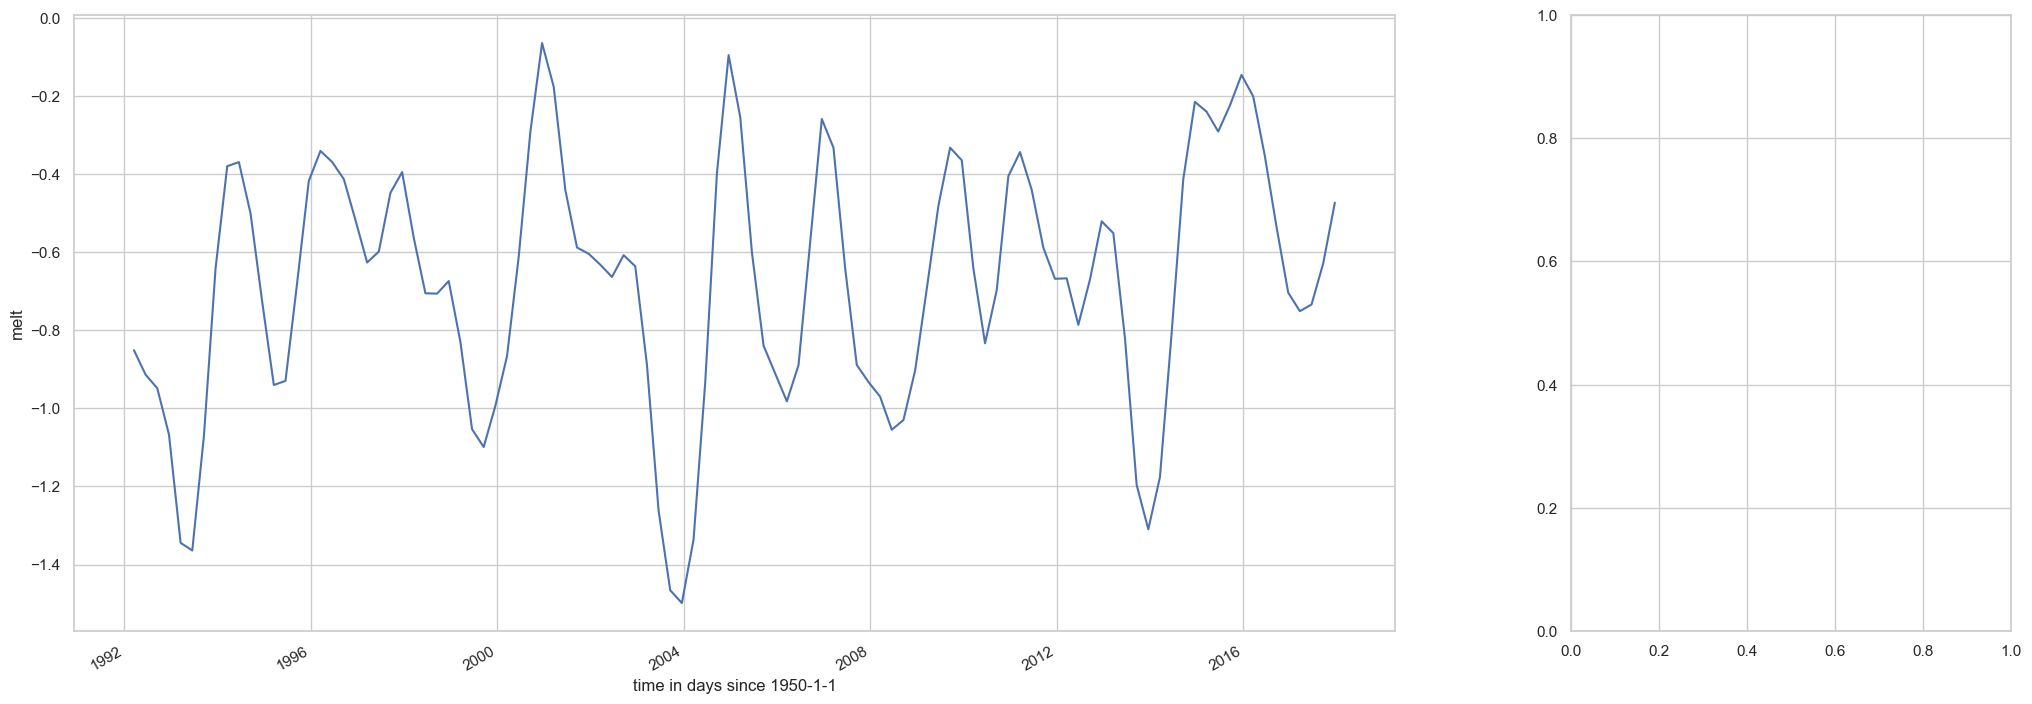

In [42]:
plt.subplots(1,2,figsize=(25,8), gridspec_kw={'width_ratios': [3, 1]})

plt.subplot(121)
obs23_melt_ts.plot(label='Original')
obs23_melt_detrend_perpixel_ts.plot(label='Detrended')
(obs23_melt_ts-obs23_melt_detrend_perpixel_ts).plot(label='Linear Function Fit', lw=3, ls='--')
plt.title('Time series of spatially averaged ice shelf basal melt rate from satellite observations (detrended)')
plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.axvspan(pd.Timestamp('2011-10-01'), pd.Timestamp('2012-05-01'), facecolor='red', alpha=0.2, label='Jump in melt rate trend?!')
plt.legend()

plt.subplot(122)
plt.plot(obs23_melt_ts-obs23_melt_detrend_perpixel_ts, lw=3, ls='--', color='green')
plt.xlabel('Time (Date Index)')
plt.ylabel('Melt rate (m/yr)')
plt.title('Linear function fit for the melt rate time series trend')

NameError: name 'obs23_melt_detrend_perpixel_ts' is not defined

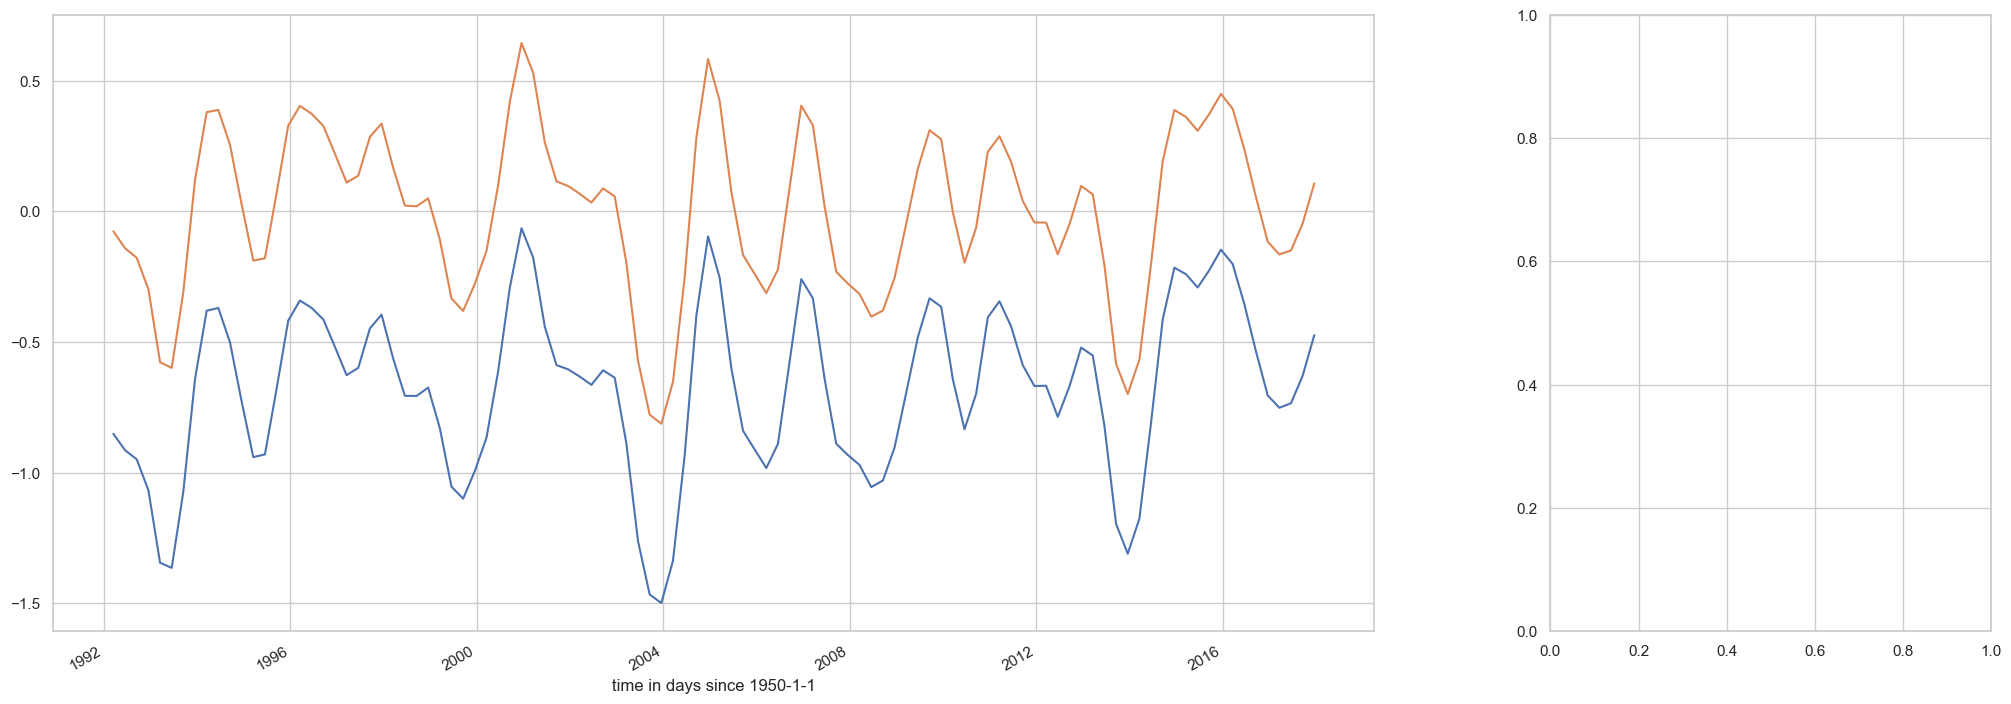

In [43]:
plt.subplots(1,2,figsize=(25,8), gridspec_kw={'width_ratios': [3, 1]})

plt.subplot(121)
obs23_melt_ts.plot(label='Original')
obs23_melt_detrend_uniform_ts.plot(label='Detrended with uniform linear trend across ice sheet')
obs23_melt_detrend_perpixel_ts.plot(label='Detrended with linear trend on a per-pixel basis')
(obs23_melt_ts-obs23_melt_detrend_uniform_ts).plot(label='Linear Function Fit (uniform)', lw=3, ls='-')
(obs23_melt_ts-obs23_melt_detrend_perpixel_ts).plot(label='Linear Function Fit (per-pixel)', lw=3, ls='--')
(obs23_melt_detrend_uniform_ts-obs23_melt_detrend_perpixel_ts).plot(label='Difference between the two detrending methods', lw=3, ls=':')
plt.title('Time series of spatially averaged ice shelf basal melt rate from satellite observations')
plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.legend()

plt.subplot(122)
(obs23_melt_ts-obs23_melt_detrend_uniform_ts).plot(label='Linear Function Fit (uniform)', lw=3, ls='-', color='C3') # uniform linear trend subtracted
(obs23_melt_ts-obs23_melt_detrend_perpixel_ts).plot(label='Linear Function Fit (per-pixel)', lw=3, ls='--', color='C4') # per-pixel linear trend subtracted
plt.xlabel('Time (Date Index)')
plt.ylabel('Melt rate (m/yr)')
plt.title('Linear function fit for the melt rate time series trend')

## RENAME

# obs23_melt_detrend_tmp_ts -> obs23_melt_detrend_uniform_ts
# obs23_melt_detrend_ts -> obs23_melt_detrend_perpixel_ts


We proceed with the detrending using **Method 2**, as it provides a "cleaner" trendline fit without the jump in 2012 for further pre-processing.

## Deseasonalize

Seasonal climatologies can be removed via two methods similar to the initial detrending step.
(1) On a per-pixel basis
(2) A uniform/average climatology

#### Deseasonalize Method 1 (per-pixel)

In [8]:
# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize 
melt_month = obs23_melt_detrend_uniform.groupby("time.month")
melt_clm = melt_month.mean("time")#.compute() # Climatologies
obs23_melt_detrend_uniform_deseasonalize = melt_month - melt_clm # Deseasonalized anomalies

#### Deseasonalize Method 2 (uniform)

In [43]:
# Deseasonalize with a uniform/average climatology

melt_month = obs23_melt_detrend_uniform_ts.groupby("time.month")
melt_clm = melt_month.mean("time")#.compute() # Climatologies
obs23_melt_detrend_uniform_deseasonalize_ts = melt_month - melt_clm # Deseasonalized anomalies

climfit = obs23_melt_detrend_uniform_ts - obs23_melt_detrend_uniform_deseasonalize_ts
obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform - climfit

#### Save dedrended and deseasonalized dataset
For future steps and iterations, we load this dataset into the notebook (done in the read dataset section above)

In [47]:
obs23_melt_detrend_uniform_deseasonalize_uniform.attrs['detrend_method'] = 'uniform linear trend across ice sheet'
obs23_melt_detrend_uniform_deseasonalize_uniform.attrs['deseason_method'] = 'uniform climatology across ice sheet'
obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.rename('melt')

In [41]:
obs23_melt_detrend_uniform_deseasonalize.to_netcdf(main_dir / DIR_processed / "obs23_melt_detrend_uniform_deseasonalize.nc", engine='h5netcdf')
obs23_melt_detrend_uniform_deseasonalize_uniform.to_netcdf(main_dir / DIR_processed / "obs23_melt_detrend_uniform_deseasonalize_uniform.nc", engine='h5netcdf')

#### Compute spatially averaged time series for the detrended and deseasonalized data

In [26]:
obs23_melt_detrend_uniform_deseasonalize_uniform_ts = obs23_melt_detrend_uniform_deseasonalize_uniform.mean(dim=['x', 'y']).compute()

In [31]:
obs23_melt_detrend_uniform_deseasonalize_uniform_ts = obs23_melt_detrend_uniform_deseasonalize_uniform_ts.melt
obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.melt

In [28]:
trend = obs23_melt_ts - obs23_melt_detrend_uniform_ts
clim = obs23_melt_detrend_uniform_ts-obs23_melt_detrend_uniform_deseasonalize_uniform_ts

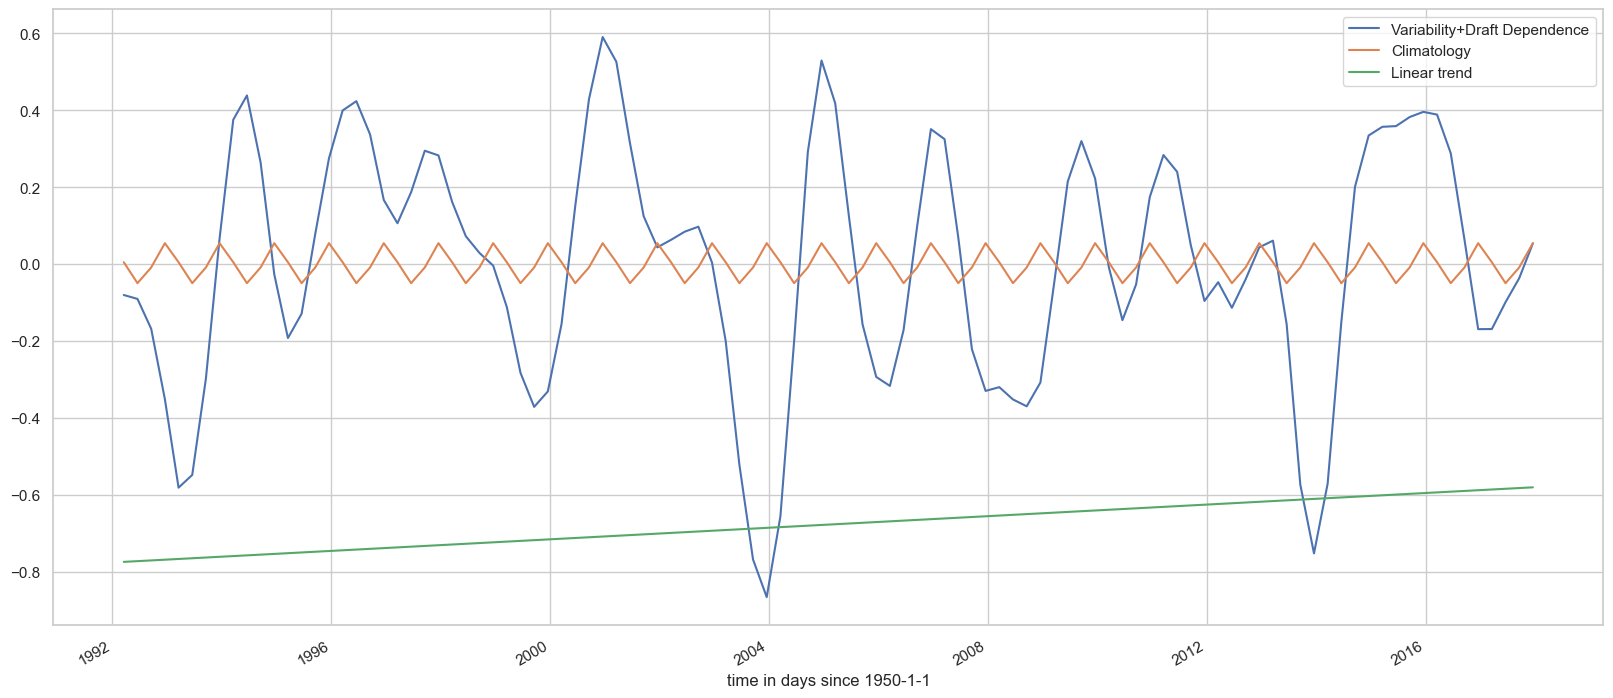

In [73]:
plt.figure(figsize=(20,8))
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(label='Variability+Draft Dependence')
#obs23_melt_detrend_uniform_ts.plot()
(obs23_melt_detrend_uniform_ts-obs23_melt_detrend_uniform_deseasonalize_uniform_ts).plot(label='Climatology')
(obs23_melt_ts-obs23_melt_detrend_uniform_ts).plot(label='Linear trend')

plt.legend()


#### Melt variability anomalies (naive method)

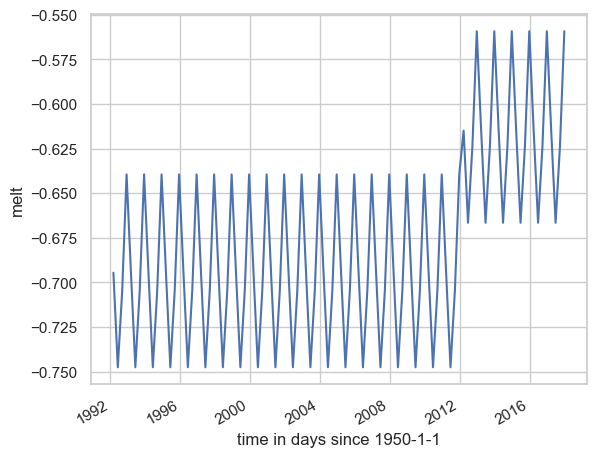

In [74]:
# Remove seasonality from the time series
# Check draft dependence on the residuals
# Check the residuals for spatial correlation

obs23_melt_anm = xr.open_dataset(main_dir / DIR_processed / FILE_basalMeltObs_deSeasonalized, chunks={"x":729, "y":729})
obs23_melt_anm_ts = obs23_melt_anm.melt.mean(dim=['x', 'y']).compute()

#obs23_melt_anm_ts.plot()
#obs23_melt_ts.plot()
(obs23_melt_ts-obs23_melt_anm_ts).plot()



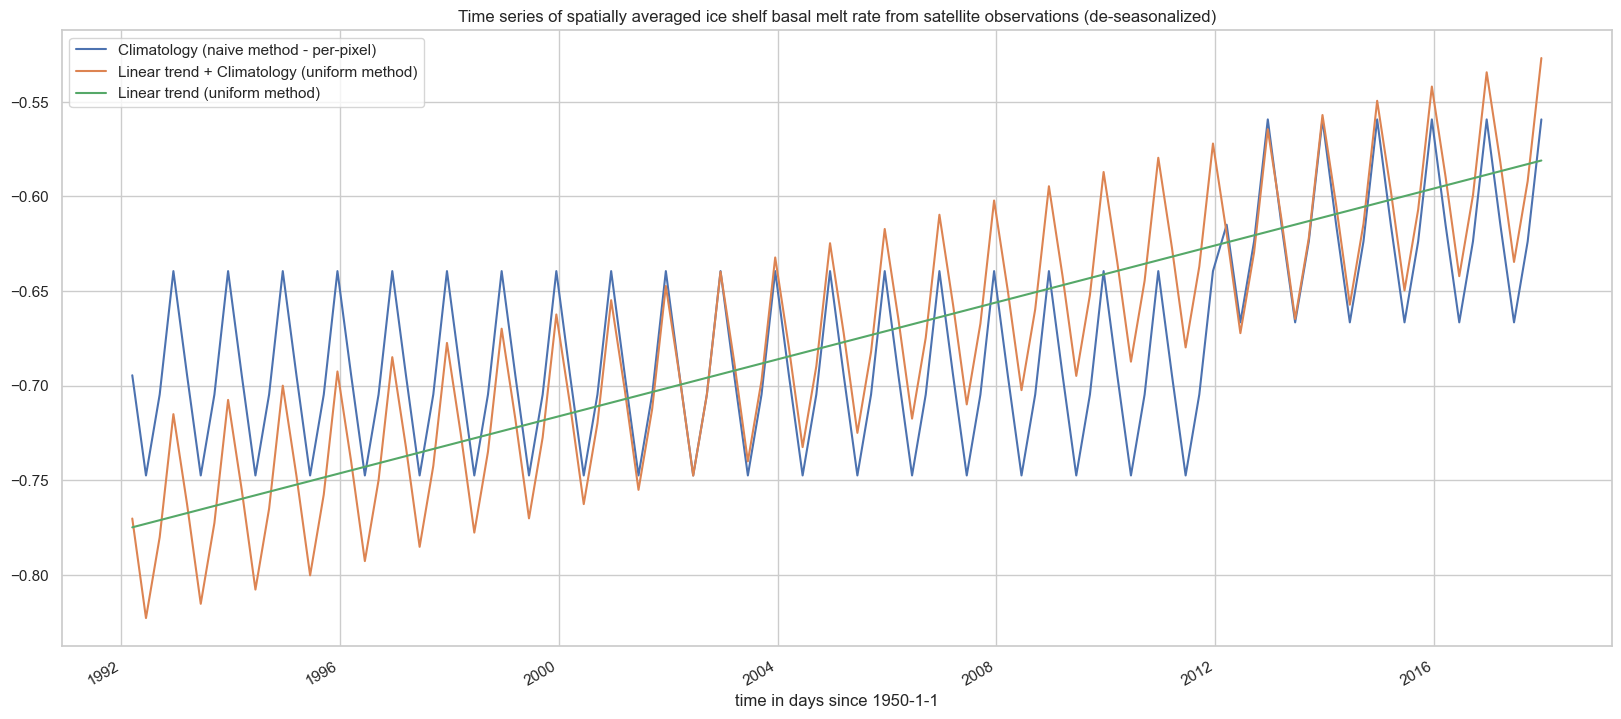

In [102]:
plt.figure(figsize=(20,8))
(obs23_melt_ts-obs23_melt_anm_ts).plot(label='Climatology (naive method - per-pixel)')
(clim.melt+trendfit).plot(label='Linear trend + Climatology (uniform method)')
trendfit.plot(label='Linear trend (uniform method)')
plt.title('Time series of spatially averaged ice shelf basal melt rate from satellite observations (de-seasonalized)')
#(-clim.melt+obs23_melt_ts-obs23_melt_anm_ts).plot()
plt.legend()

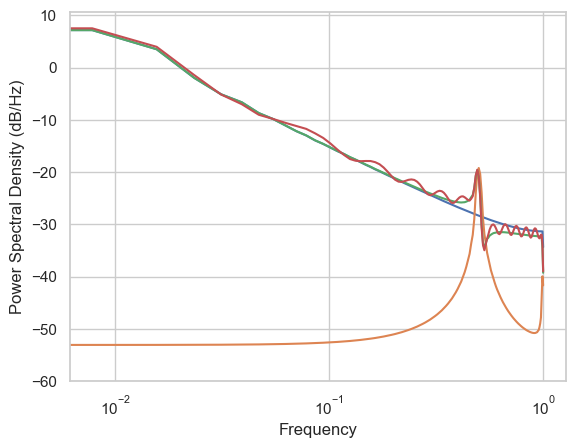

In [82]:
plt.psd(trendfit);
plt.psd(clim.melt);
plt.psd(trendfit+clim.melt);
plt.xscale('log')
plt.psd(obs23_melt_ts-obs23_melt_anm_ts);

(2500.0, 0.0)

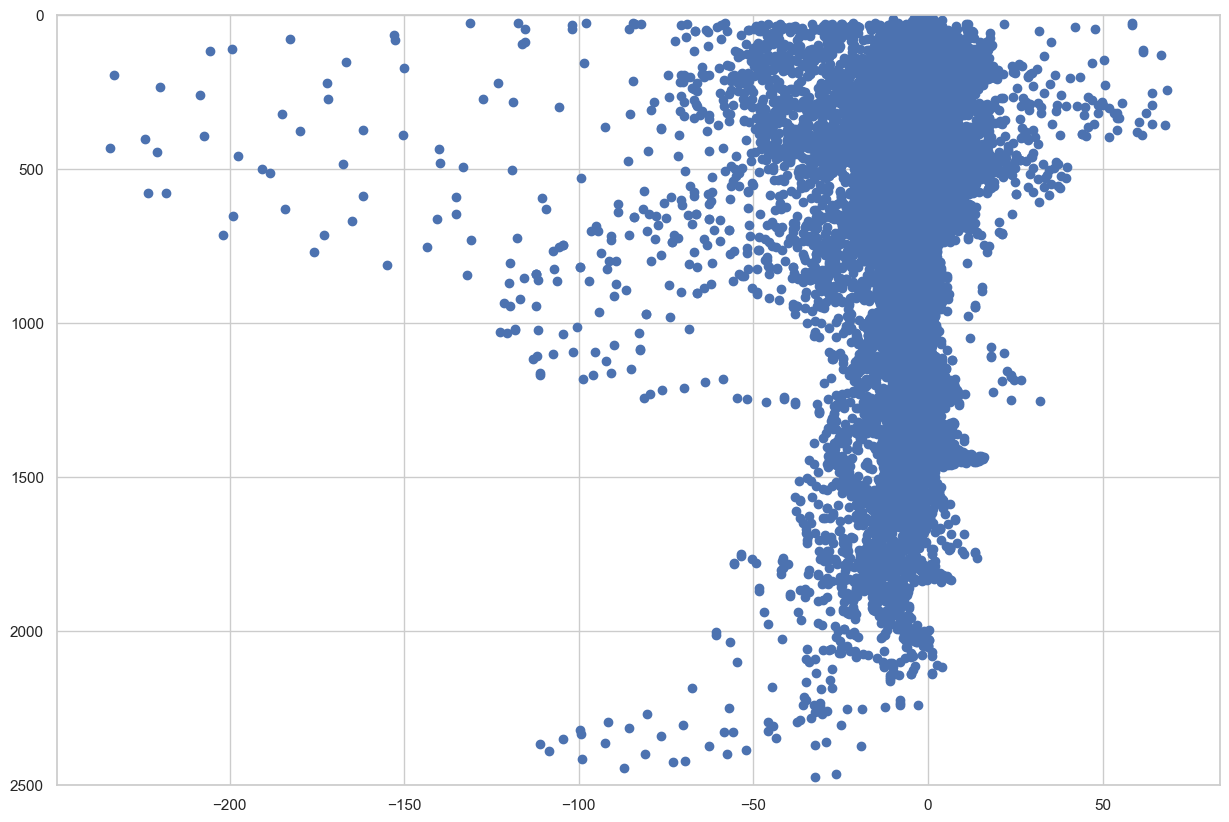

In [79]:
plt.figure(figsize=(15,10))
plt.scatter(obs23_melt_tm, obs23_draft_tm)
plt.ylim(2500,0)

In [ ]:
# Deseasonalize: Remove climatologies to isolate anomalies / deseasonalize
obs23_melt_month = obs23_melt.groupby("time.month")
obs23_melt_clm = obs23_melt_month.mean("time").compute() # Climatologies
obs23_melt_anm = (obs23_melt_month - obs23_melt_clm).compute() # Deseasonalized anomalies

In [ ]:
obs23_melt_anm_ts = obs23_melt_anm.mean(['x', 'y']).compute()

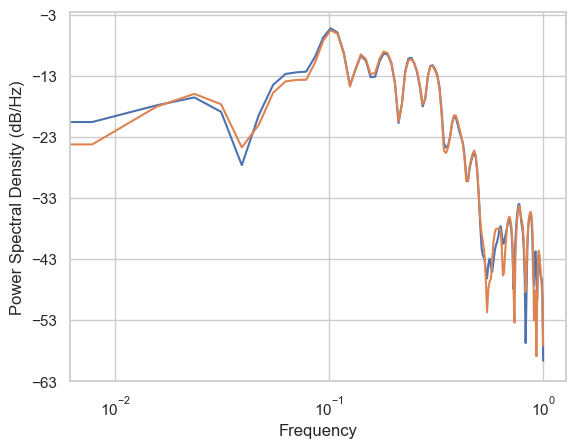

In [104]:
plt.psd(obs23_melt_anm_ts);
plt.psd(obs23_melt_detrend_uniform_deseasonalize_uniform_ts);
plt.xscale('log')

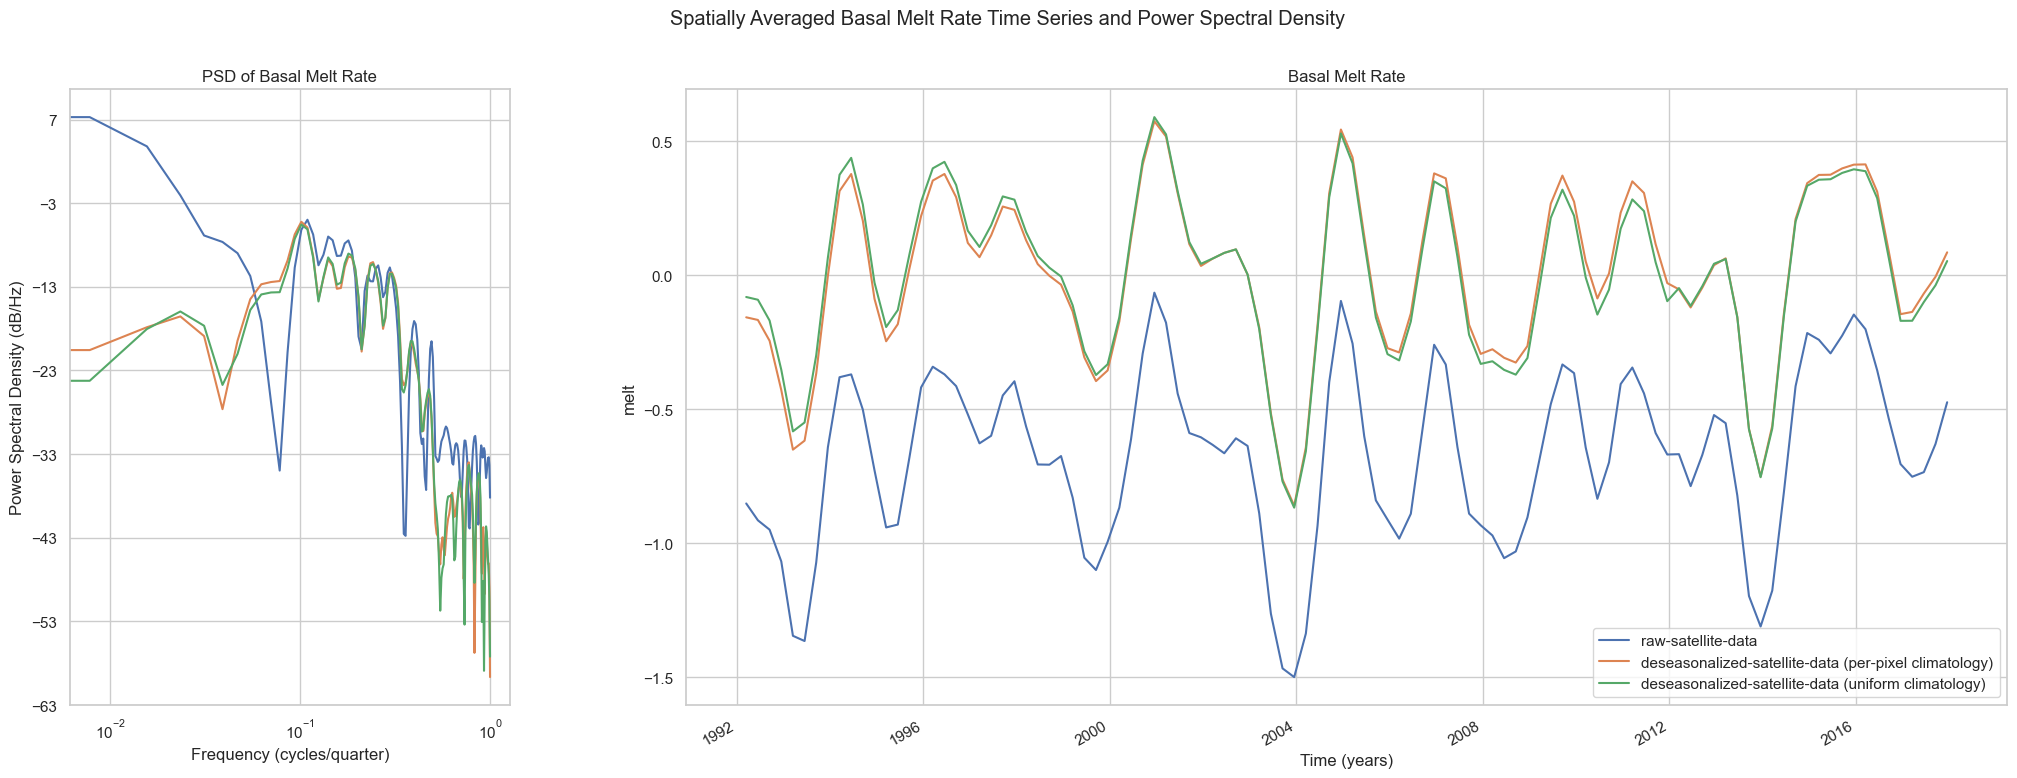

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8), gridspec_kw={'width_ratios': [1, 3]})

axs[0].psd(obs23_melt_ts);
axs[0].psd(obs23_melt_anm_ts);
axs[0].psd(obs23_melt_detrend_uniform_deseasonalize_uniform_ts);
axs[0].set_xlabel('Frequency (cycles/quarter)')
axs[0].set_xscale('log')
axs[0].set_title('PSD of Basal Melt Rate')

obs23_melt_ts.plot(ax=axs[1], label='raw-satellite-data')
obs23_melt_anm_ts.plot(ax=axs[1], label='deseasonalized-satellite-data (per-pixel climatology)')
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(ax=axs[1], label='deseasonalized-satellite-data (uniform climatology)')
#axs[1].plot(obs23_melt_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Melt Rate')

plt.legend()
fig.suptitle('Spatially Averaged Basal Melt Rate Time Series and Power Spectral Density')
plt.show()

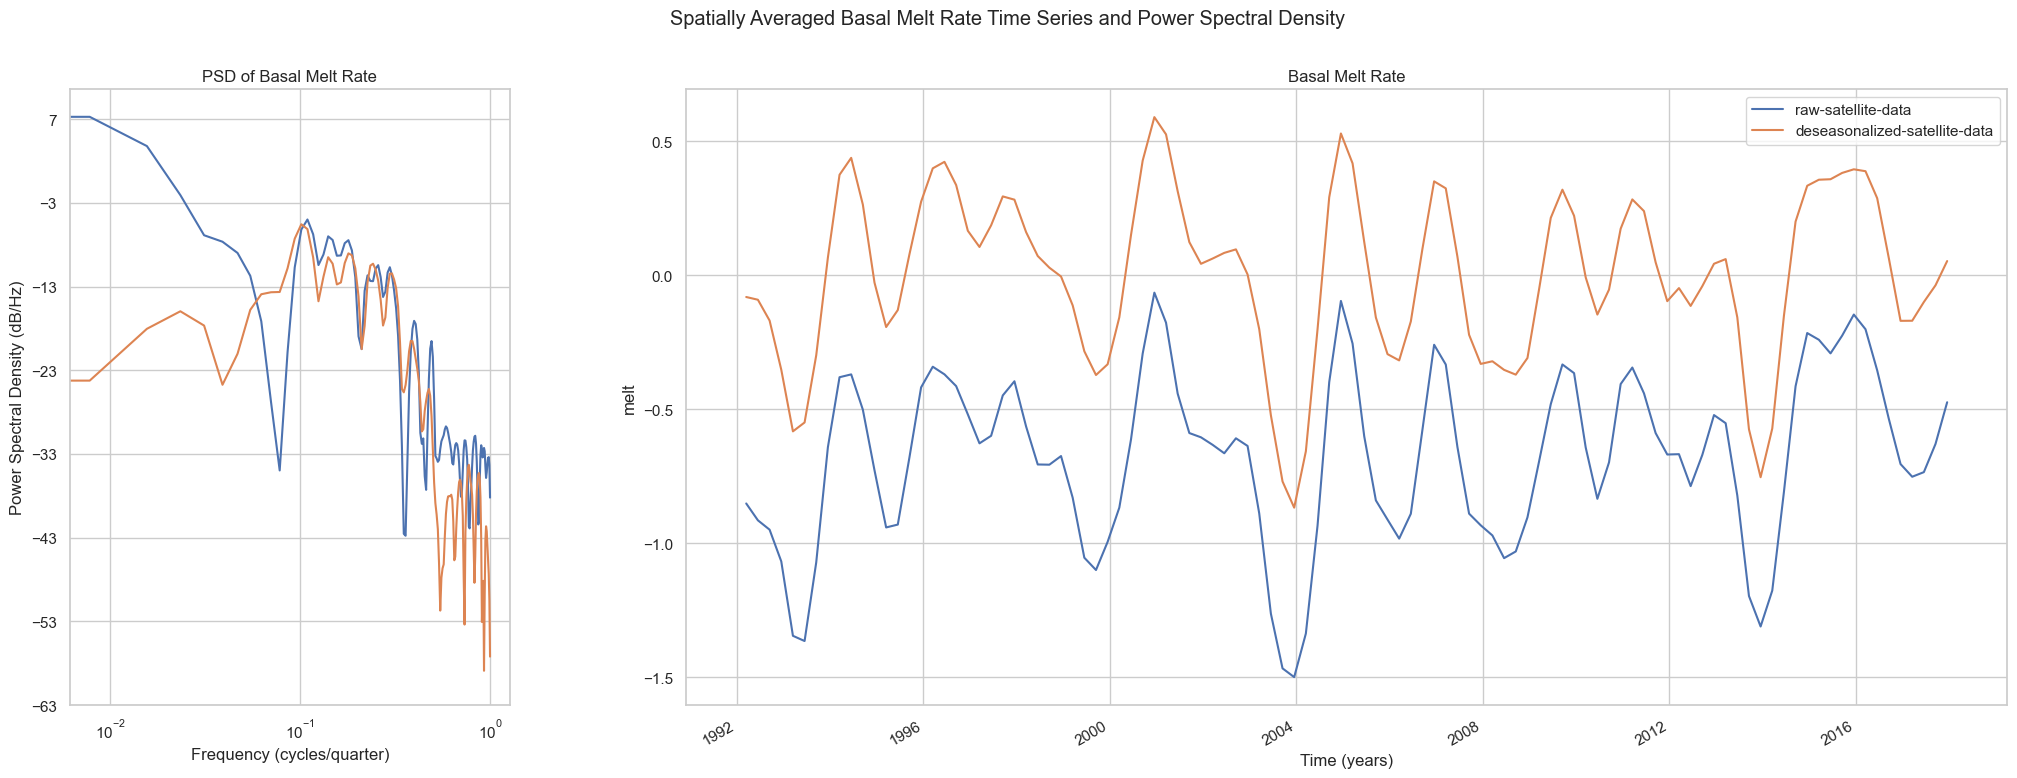

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8), gridspec_kw={'width_ratios': [1, 3]})

axs[0].psd(obs23_melt_ts);
axs[0].psd(obs23_melt_detrend_uniform_deseasonalize_uniform_ts);
axs[0].set_xlabel('Frequency (cycles/quarter)')
axs[0].set_xscale('log')
axs[0].set_title('PSD of Basal Melt Rate')

obs23_melt_ts.plot(ax=axs[1], label='raw-satellite-data')
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(ax=axs[1], label='deseasonalized-satellite-data')
#axs[1].plot(obs23_melt_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Melt Rate')

plt.legend()
fig.suptitle('Spatially Averaged Basal Melt Rate Time Series and Power Spectral Density')
plt.show()

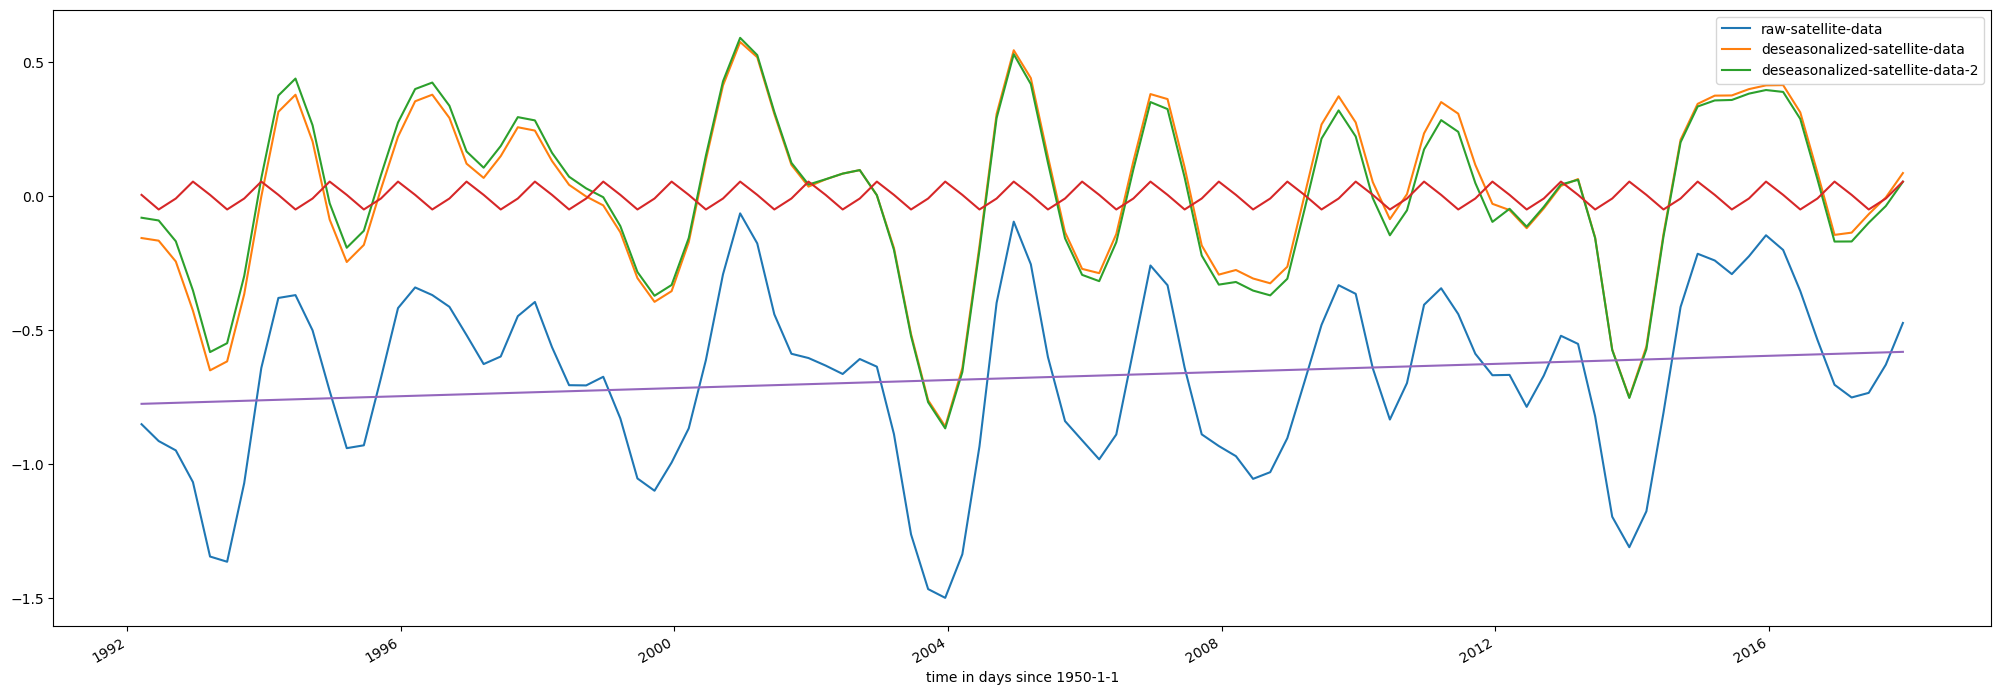

In [86]:
plt.figure(figsize=(25,8))
obs23_melt_ts.plot(label='raw-satellite-data')
obs23_melt_anm_ts.plot(label='deseasonalized-satellite-data')
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(label='deseasonalized-satellite-data-2')
#(obs23_melt_ts - obs23_melt_anm_ts).plot(label='climatology')
climfit.plot()
trendfit.plot()
#axs[1].plot(obs23_melt_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Melt Rate')

plt.legend()

## Dedraft
We now clip the data to specific ice shelves.

In [5]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs)
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

In [10]:
obs23_melt_tm.rio.write_crs("epsg:3031",inplace=True);
obs23_draft_tm.rio.write_crs("epsg:3031",inplace=True);
obs23_draft.rio.write_crs("epsg:3031",inplace=True);
obs23_melt_detrend_uniform_deseasonalize_uniform.rio.write_crs("epsg:3031",inplace=True);
obs23_melt_detrend_uniform.rio.write_crs("epsg:3031",inplace=True);

NameError: name 'obs23_melt_detrend_uniform' is not defined

In [47]:
obs23_melt_detrend_uniform_deseasonalize_uniform_tm = obs23_melt_detrend_uniform_deseasonalize_uniform.mean(dim='time').compute()

In [7]:
icems.name.values

array(['Filchner-Ronne', 'Ross', 'Antarctica', 'Peninsula',
       'West Antarctica', 'East Antarctica', 'IMBIE1', 'IMBIE2', 'IMBIE3',
       'IMBIE4', 'IMBIE5', 'IMBIE6', 'IMBIE7', 'IMBIE8', 'IMBIE9',
       'IMBIE10', 'IMBIE11', 'IMBIE12', 'IMBIE13', 'IMBIE14', 'IMBIE15',
       'IMBIE16', 'IMBIE17', 'IMBIE18', 'IMBIE19', 'IMBIE20', 'IMBIE21',
       'IMBIE22', 'IMBIE23', 'IMBIE24', 'IMBIE25', 'IMBIE26', 'IMBIE27',
       'Abbot', 'Amery', 'Atka', 'Aviator', 'Bach', 'Baudouin',
       'Borchgrevink', 'Brahms', 'Brunt_Stancomb', 'Campbell', 'Cheetham',
       'Conger_Glenzer', 'Cook', 'Cosgrove', 'Crosson', 'Dennistoun',
       'Dibble', 'Dotson', 'Drygalski', 'Edward_VIII', 'Ekstrom',
       'Ferrigno', 'Filchner', 'Fimbul', 'Fitzgerald', 'Frost',
       'GeikieInlet', 'George_VI', 'Getz', 'Gillet', 'Hamilton', 'Hannan',
       'HarbordGlacier', 'Helen', 'Holmes', 'HolmesWest', 'Hull',
       'Jelbart', 'Land', 'Larsen_B', 'Larsen_C', 'Larsen_D', 'Larsen_E',
       'Larsen_F', 'Larse

In [9]:
# given ice shelf name, find the index number in icems
def find_ice_shelf_index(ice_shelf_name):
    return icems[icems['name']==ice_shelf_name].index[0]



In [8]:
i = find_ice_shelf_index('Thwaites')
# obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.melt

mlt = clip_data(obs23_melt_detrend_uniform_deseasonalize_uniform_tm, i)
h = clip_data(obs23_draft_tm, i)

# Reshape mlt and h data for linear regression
mlt_stack = mlt.stack(z=('x', 'y'))#.values.reshape(-1,1)
h_stack = h.stack(z=('x', 'y'))#.values.reshape(-1,1)

mlt_stack_noNaN = mlt_stack.fillna(0)
h_stack_noNaN = h_stack.fillna(0)

mlt_stack_noNaN_vals = mlt_stack_noNaN.values.reshape(-1,1)
h_stack_noNaN_vals = h_stack_noNaN.values.reshape(-1,1)

# X is the independent variable, y is the dependent variable
# X is the ice draft, y is the melt rate
X = h_stack_noNaN_vals
y = mlt_stack_noNaN_vals
reg = LinearRegression().fit(X,y)
print("X is:")
print(X)
print("Shape of X is: {}".format(X.shape))
print("Coefficient (slope) is: ")
print(reg.coef_)
print("Intercept is: ")
print(reg.intercept_)
print("y is:")
print(y)
#print("Predicted y for X = [3,5] is:")
#print(reg.predict(np.array([[3,5]])))

NameError: name 'obs23_melt_detrend_uniform_deseasonalize_uniform_tm' is not defined

In [29]:
i = find_ice_shelf_index('Getz')
# obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.melt

mlt = clip_data(obs23_melt_tm, i)
h = clip_data(obs23_draft_tm, i)

# Reshape mlt and h data for linear regression
mlt_stack = mlt.stack(z=('x', 'y'))#.values.reshape(-1,1)
h_stack = h.stack(z=('x', 'y'))#.values.reshape(-1,1)

mlt_stack_noNaN = mlt_stack.fillna(0)
h_stack_noNaN = h_stack.fillna(0)

mlt_stack_noNaN_vals = mlt_stack_noNaN.values.reshape(-1,1)
h_stack_noNaN_vals = h_stack_noNaN.values.reshape(-1,1)

# X is the independent variable, y is the dependent variable
# X is the ice draft, y is the melt rate
X = h_stack_noNaN_vals
y = mlt_stack_noNaN_vals
reg = LinearRegression().fit(X,y)
print("X is:")
print(X)
print("Shape of X is: {}".format(X.shape))
print("Coefficient (slope) is: ")
print(reg.coef_)
print("Intercept is: ")
print(reg.intercept_)
print("y is:")
print(y)
#print("Predicted y for X = [3,5] is:")
#print(reg.predict(np.array([[3,5]])))

X is:
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Shape of X is: (129360, 1)
Coefficient (slope) is: 
[[-0.00927342]]
Intercept is: 
[-0.00094041]
y is:
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [30]:
# Model predicted value array for melt rate, i.e., the draft dependent component of the melt rate
y_pred = reg.predict(X)
mlt_pred_stack_noNaN_vals = y_pred.reshape(-1)
# Create a new xarray DataArray with the predicted melt rate values
mlt_pred_stack_noNaN = mlt_stack_noNaN.copy(data=mlt_pred_stack_noNaN_vals)
# Place NaN values in mlt_pred_stack based on the location of NaN values in mlt_stack
mlt_pred_stack = mlt_pred_stack_noNaN.where(~mlt_stack.isnull(), np.nan)
# Reshape the predicted melt rate DataArray to the original shape of the ice shelf
mlt_pred = mlt_pred_stack.unstack('z').transpose()

#print("Shape of h: {}".format(h.shape))
print("Shape of mlt: {}".format(mlt.shape))
print("Shape of mlt_stack: {}".format(mlt_stack.shape))
print("Shape of mlt_stack_noNaN: {}".format(mlt_stack_noNaN.shape))
print("Shape of mlt_stack_noNaN_vals: {}".format(mlt_stack_noNaN_vals.shape))
print("Shape of mlt_pred_stack_noNaN_vals: {}".format(mlt_pred_stack_noNaN_vals.shape))
print("Shape of mlt_pred_stack_noNaN: {}".format(mlt_pred_stack_noNaN.shape))
print("Shape of mlt_pred_stack: {}".format(mlt_pred_stack.shape))
print("Shape of mlt_pred: {}".format(mlt_pred.shape))

Shape of mlt: (294, 440)
Shape of mlt_stack: (129360,)
Shape of mlt_stack_noNaN: (129360,)
Shape of mlt_stack_noNaN_vals: (129360, 1)
Shape of mlt_pred_stack_noNaN_vals: (129360,)
Shape of mlt_pred_stack_noNaN: (129360,)
Shape of mlt_pred_stack: (129360,)
Shape of mlt_pred: (294, 440)


(2500.0, 0.0)

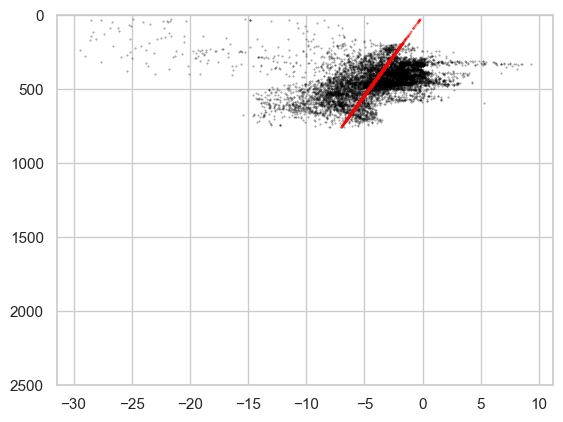

In [36]:
plt.scatter(mlt, h, color='black', alpha=0.4, s=0.2)
plt.scatter(mlt_pred, h, color='red', alpha=0.4, s=0.2)
plt.ylim(2500,0)

In [11]:
obs23_melt_tm = obs23_prepared_mean.melt
obs23_draft_tm = obs23_prepared_mean.draft

In [18]:
obs23_prepared = write_crs(obs23_prepared)

In [40]:
np.squeeze(w).shape

(597715,)

In [48]:
weights

<xarray.DataArray 'melt' (y: 691, x: 865)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 7.958e+05 7.978e+05 ... 2.453e+06 2.455e+06
  * y            (y) float64 1.201e+06 1.199e+06 ... -1.219e+05 -1.238e+05
    spatial_ref  int64 0

In [66]:
insar_gl_shape = gpd.read_file(main_dir / DIR_external / "NSIDC-0498_2-20250709_194639/InSAR_GL_Antarctica_v02.shp")

In [86]:
print(insar_gl_shape.crs)
insar_gl_shape_proj = insar_gl_shape.to_crs("EPSG:3031")
print(insar_gl_shape_proj.crs)

epsg:4326
EPSG:3031


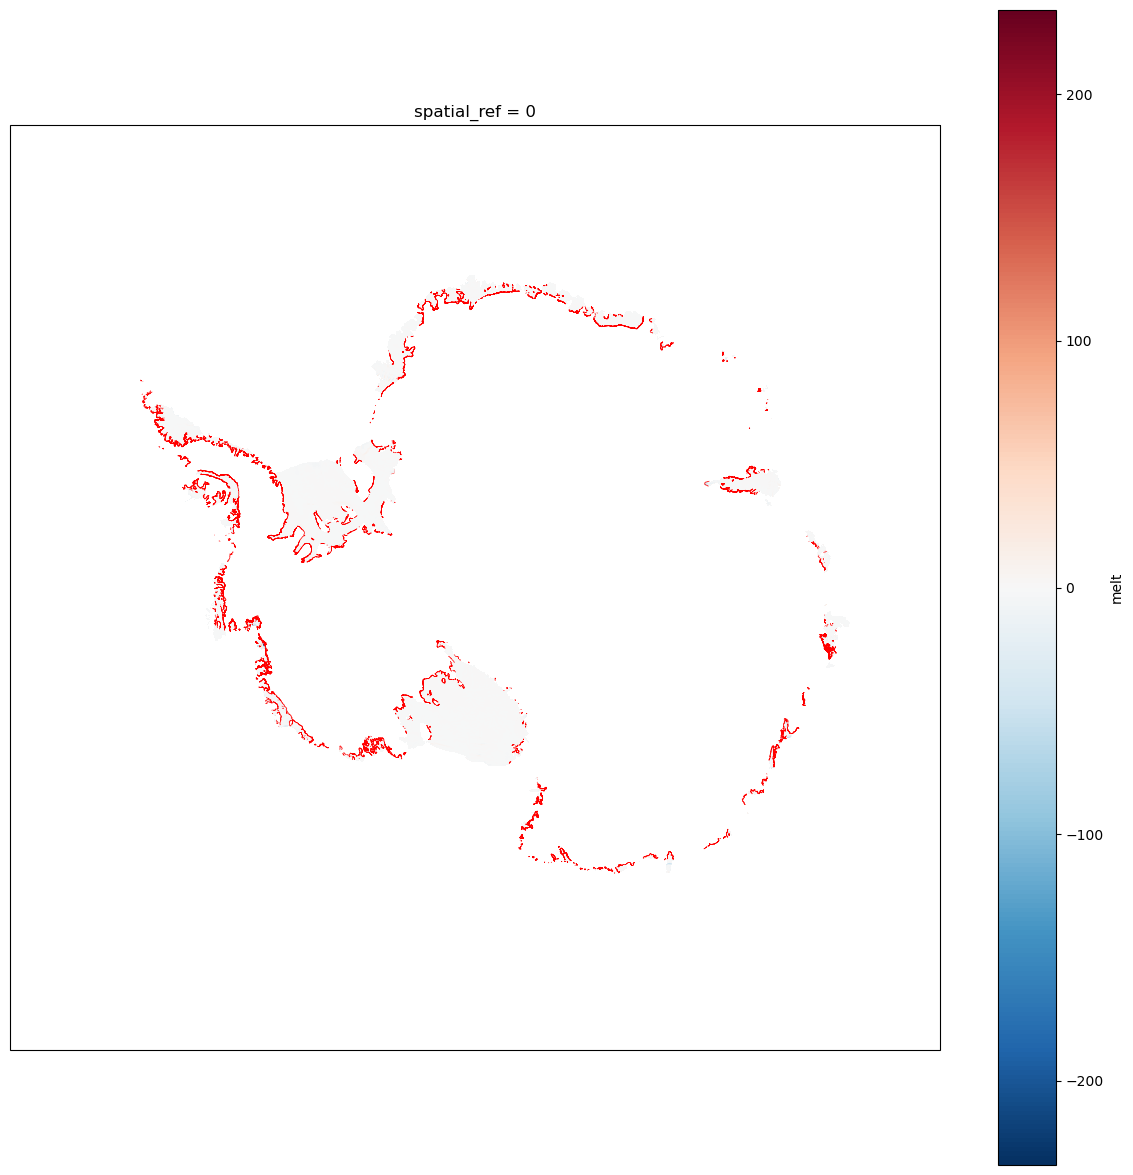

In [93]:
# Plot a map of antarctica and the grounding line positions from this shapefile insar_gl_shape in south stereo projection
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
#ax.coastlines(resolution='50m', lw=0.5)
#ax.add_feature(cartopy.feature.LAND, color='lightgrey', zorder=1)
#ax.add_feature(cartopy.feature.OCEAN, color='lightblue', zorder=0)
#ax.add_feature(cartopy.feature.LAKES, color='lightblue', zorder=0)
#ax.add_feature(cartopy.feature.RIVERS, color='blue', zorder=0)
#ax.add_feature(cartopy.feature.BORDERS, linestyle=':', zorder=2)
ax.add_geometries(insar_gl_shape_proj.geometry, crs=ccrs.SouthPolarStereo(),
                  edgecolor='red', facecolor='none', lw=0.5, zorder=3)
ax.set_title('Antarctica Grounding Line Positions from InSAR GL Dataset', fontsize=16)
obs23_melt_tm.plot(ax=ax)
#h.plot(ax=ax)
plt.show()

In [96]:
obs23_melt_tm.min()

<xarray.DataArray 'melt' ()>
array(-234.22927856)
Coordinates:
    spatial_ref  int64 0

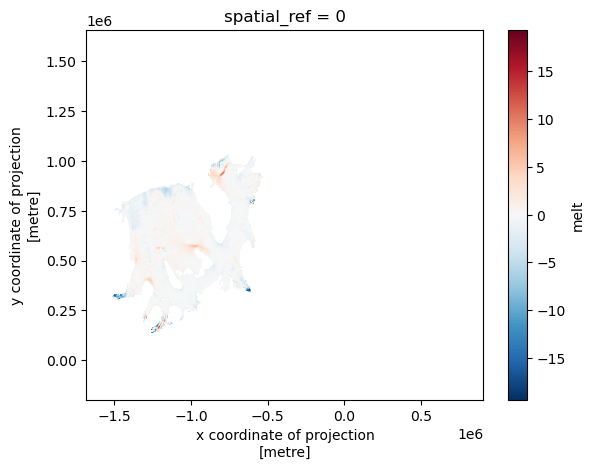

In [83]:
mlt.min()

<xarray.DataArray 'melt' ()>
array(-111.0865097)
Coordinates:
    spatial_ref  int64 0

In [59]:
print(f"Cumulative melt rate for ice shelf {icems.name.values[i]}: {mlt_is_cuml:.2f} Gt/yr")
print(f"Cumulative draft-dependent melt rate for ice shelf {icems.name.values[i]}: {mlt_pred_is_cuml:.2f} Gt/yr")

Cumulative melt rate for ice shelf Amery: -63.39 Gt/yr
Cumulative draft-dependent melt rate for ice shelf Amery: -7.69 Gt/yr


## Distance to grounding line: vertex

In [106]:
import numpy as np
from shapely.geometry import Point
from shapely.ops import unary_union
from scipy.spatial import cKDTree

# 1. Combine all grounding line geometries into a single MultiLineString
gl_union = unary_union(insar_gl_shape.to_crs(icems.crs).geometry)

# 2. Extract all points from the grounding line geometry
gl_points = []
for geom in gl_union.geoms if hasattr(gl_union, 'geoms') else [gl_union]:
    if geom.geom_type == 'LineString':
        gl_points.extend(np.array(geom.coords))
    elif geom.geom_type == 'MultiLineString':
        for line in geom.geoms:
            gl_points.extend(np.array(line.coords))

gl_points = np.array(gl_points)

# 3. Build KDTree for grounding line points
tree = cKDTree(gl_points)

# 4. Get coordinates of each grid cell in the clipped melt array
x_coords, y_coords = np.meshgrid(mlt['x'].values, mlt['y'].values, indexing='xy')
points_flat = np.column_stack([x_coords.ravel(), y_coords.ravel()])

# 5. Query nearest distance for all points at once
distances, _ = tree.query(points_flat)
distances_2d = distances.reshape(mlt.shape)

# 6. Convert distances to weights (inverse distance)
epsilon = 1e-6
weights_dist = 1 / (distances_2d + epsilon)
weights_dist = np.where(np.isnan(mlt.values), np.nan, weights_dist)
weights_dist = weights_dist / np.nansum(weights_dist)
weights = mlt.copy(data=weights_dist)

## True minimum distance to grounding line

In [112]:
from shapely.geometry import Point, LineString
from shapely.ops import unary_union
from shapely.strtree import STRtree

# 1. Combine all grounding line geometries into a single MultiLineString
gl_union = unary_union(insar_gl_shape.to_crs(icems.crs).geometry)

# 2. Break MultiLineString into individual LineStrings for STRtree
if gl_union.geom_type == 'MultiLineString':
    gl_lines = list(gl_union.geoms)
elif gl_union.geom_type == 'LineString':
    gl_lines = [gl_union]
else:
    raise ValueError("Unexpected geometry type for grounding line.")

gl_lines = [g if isinstance(g, LineString) else LineString(g) for g in gl_lines]
# 3. Build STRtree for fast nearest-segment lookup
tree = STRtree(gl_lines)

# 4. Prepare grid cell coordinates
x_coords, y_coords = np.meshgrid(mlt['x'].values, mlt['y'].values, indexing='xy')
points_flat = np.column_stack([x_coords.ravel(), y_coords.ravel()])

# 5. For each grid cell, find the nearest grounding line segment and compute true distance
def nearest_distance(pt_xy):
    pt = Point(pt_xy)
    nearest = tree.nearest(pt)
    # If nearest is not a geometry, try to extract the geometry
    if hasattr(nearest, 'geometry'):
        nearest_geom = nearest.geometry
    else:
        nearest_geom = nearest
    return pt.distance(nearest_geom)

# Vectorized computation (can be parallelized if needed)
from tqdm import tqdm  # Optional: for progress bar
distances = np.array([nearest_distance(xy) for xy in tqdm(points_flat, desc="Computing distances")])
distances_2d = distances.reshape(mlt.shape)

Computing distances:   0%|          | 0/597715 [00:00<?, ?it/s]

TypeError: One of the arguments is of incorrect type. Please provide only Geometry objects.

Cumulative melt rate for ice shelf Amery: -63.39 Gt/yr
Cumulative draft-dependent melt rate for ice shelf Amery: -233.13 Gt/yr
Cumulative melt rate for ice shelf Getz: -296.33 Gt/yr
Cumulative draft-dependent melt rate for ice shelf Getz: -537.39 Gt/yr
Cumulative melt rate for ice shelf Pine_Island: -219.22 Gt/yr
Cumulative draft-dependent melt rate for ice shelf Pine_Island: -443.29 Gt/yr
Cumulative melt rate for ice shelf Eastern_Ross: -37.26 Gt/yr
Cumulative draft-dependent melt rate for ice shelf Eastern_Ross: 17.27 Gt/yr
Cumulative melt rate for ice shelf George_VI: -140.81 Gt/yr
Cumulative draft-dependent melt rate for ice shelf George_VI: -185.78 Gt/yr
Cumulative melt rate for ice shelf Filchner-Ronne: -148.87 Gt/yr
Cumulative draft-dependent melt rate for ice shelf Filchner-Ronne: -603.82 Gt/yr


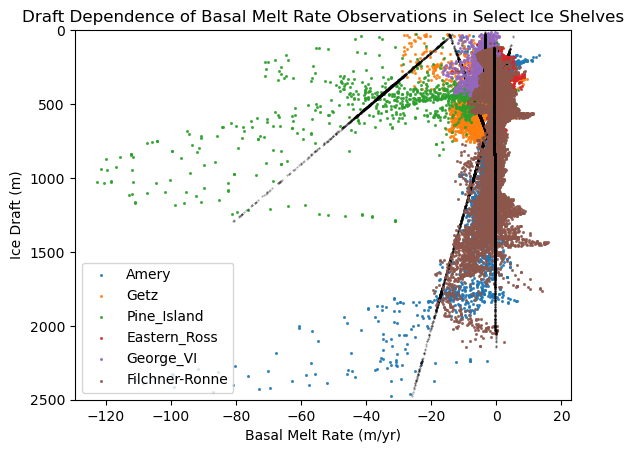

In [116]:
ice_shelves_for_figure = ['Amery', 'Getz', 'Pine_Island', 'Eastern_Ross', 'George_VI', 'Filchner-Ronne']
#ice_shelves_for_figure = ['Filchner-Ronne']
#ice_shelves_for_figure = ['Amery']
for shelfname in ice_shelves_for_figure:
    i = find_ice_shelf_index(shelfname)
    # obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.melt

    mlt = clip_data(obs23_melt_tm, i, icems)
    h = clip_data(obs23_draft_tm, i, icems)
    # 1. Combine all grounding line geometries into a single MultiLineString
    gl_union = unary_union(insar_gl_shape.to_crs(icems.crs).geometry)

    # 2. Extract all points from the grounding line geometry
    gl_points = []
    for geom in gl_union.geoms if hasattr(gl_union, 'geoms') else [gl_union]:
        if geom.geom_type == 'LineString':
            gl_points.extend(np.array(geom.coords))
        elif geom.geom_type == 'MultiLineString':
            for line in geom.geoms:
                gl_points.extend(np.array(line.coords))

    gl_points = np.array(gl_points)

    # 3. Build KDTree for grounding line points
    tree = cKDTree(gl_points)

    # 4. Get coordinates of each grid cell in the clipped melt array
    x_coords, y_coords = np.meshgrid(mlt['x'].values, mlt['y'].values, indexing='xy')
    points_flat = np.column_stack([x_coords.ravel(), y_coords.ravel()])

    # 5. Query nearest distance for all points at once
    distances, _ = tree.query(points_flat)
    distances_2d = distances.reshape(mlt.shape)

    # 6. Convert distances to weights (inverse distance)
    epsilon = 1e-6
    weights_dist = 1 / (distances_2d + epsilon)
    weights_dist = np.where(np.isnan(mlt.values), np.nan, weights_dist)
    #weights_dist = weights_dist / np.nansum(weights_dist)
    weights = mlt.copy(data=weights_dist)
    weights = abs(mlt)/(abs(mlt).sum()*weights)
    # Reshape mlt and h data for linear regression
    mlt_stack = mlt.stack(z=('x', 'y'))#.values.reshape(-1,1)
    h_stack = h.stack(z=('x', 'y'))#.values.reshape(-1,1)
    weights_stack = weights.stack(z=('x', 'y'))

    mlt_stack_noNaN = mlt_stack.fillna(0)
    h_stack_noNaN = h_stack.fillna(0)
    weights_stack_noNaN = weights_stack.fillna(0)

    mlt_stack_noNaN_vals = mlt_stack_noNaN.values.reshape(-1,1)
    h_stack_noNaN_vals = h_stack_noNaN.values.reshape(-1,1)
    weights_stack_noNaN_vals = weights_stack_noNaN.values.reshape(-1,1)

    # X is the independent variable, y is the dependent variable
    # X is the ice draft, y is the melt rate
    X = h_stack_noNaN_vals
    y = mlt_stack_noNaN_vals
    w = np.squeeze(weights_stack_noNaN_vals)
    #w = weights_stack_noNaN_vals.reshape(-1,1)
    # Mask out the values where draft is under 1800 m and then do the regression
    #X = X[mask]
    #y = y[mask]
    #w = w[mask]
    #w = np.squeeze(w)
    reg = LinearRegression().fit(X,y,w)


    # Model predicted value array for melt rate, i.e., the draft dependent component of the melt rate
    y_pred = reg.predict(X)
    mlt_pred_stack_noNaN_vals = y_pred.reshape(-1)
    # Create a new xarray DataArray with the predicted melt rate values
    mlt_pred_stack_noNaN = mlt_stack_noNaN.copy(data=mlt_pred_stack_noNaN_vals)
    # Place NaN values in mlt_pred_stack based on the location of NaN values in mlt_stack
    mlt_pred_stack = mlt_pred_stack_noNaN.where(~mlt_stack.isnull(), np.nan)
    # Reshape the predicted melt rate DataArray to the original shape of the ice shelf
    mlt_pred = mlt_pred_stack.unstack('z').transpose()
    plt.scatter(mlt, h, alpha=0.8, s=1.5, label=shelfname)
    plt.scatter(mlt_pred, h, color='black', alpha=0.4, s=0.2)
    plt.ylim(2500,0)
    mlt_is = mlt*3*3*1e6*917
    mlt_is_cuml = mlt_is.sum()*1e-12
    mlt_pred_is = mlt_pred*3*3*1e6*917
    mlt_pred_is_cuml = mlt_pred_is.sum()*1e-12
    print(f"Cumulative melt rate for ice shelf {icems.name.values[i]}: {mlt_is_cuml:.2f} Gt/yr")
    print(f"Cumulative draft-dependent melt rate for ice shelf {icems.name.values[i]}: {mlt_pred_is_cuml:.2f} Gt/yr")


plt.xlabel('Basal Melt Rate (m/yr)')
plt.ylabel('Ice Draft (m)')
plt.title('Draft Dependence of Basal Melt Rate Observations in Select Ice Shelves')
plt.legend(loc='lower left')


In [148]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from scipy.spatial import cKDTree
from sklearn.linear_model import LinearRegression

def get_distance_to_gl(mlt, icems, insar_gl_shape):
    """Returns 2D array of distances from each grid cell to nearest grounding line."""
    gl_union = unary_union(insar_gl_shape.to_crs(icems.crs).geometry)
    gl_points = []
    for geom in gl_union.geoms if hasattr(gl_union, 'geoms') else [gl_union]:
        if geom.geom_type == 'LineString':
            gl_points.extend(np.array(geom.coords))
        elif geom.geom_type == 'MultiLineString':
            for line in geom.geoms:
                gl_points.extend(np.array(line.coords))
    gl_points = np.array(gl_points)
    tree = cKDTree(gl_points)
    x_coords, y_coords = np.meshgrid(mlt['x'].values, mlt['y'].values, indexing='xy')
    points_flat = np.column_stack([x_coords.ravel(), y_coords.ravel()])
    distances, _ = tree.query(points_flat)
    return distances.reshape(mlt.shape)

def draft_threshold_weight(h, threshold=1000):
    """
    Draft-Thresholded Melt Weight
    Only weight points where draft is deeper than a threshold (e.g., 500 m or 1000 m):
    """
    w = np.where(h.values > threshold, 1.0, 0.0)
    w[np.isnan(h.values)] = np.nan
    return w

def melt_x_inv_distance_weight(mlt, distances_2d, a=1, b=1):
    """
    Distance-to-Grounding-Line + Melt (Product)
    Emphasize points near the grounding line and with high melt
    """
    epsilon = 1e-6
    w = (np.abs(mlt.values)**a) * (1.0/(distances_2d + epsilon))**b
    w[np.isnan(mlt.values)] = np.nan
    return w

def melt_x_draft_weight(mlt, h, a=1, b=1):
    w = (np.abs(mlt.values)**a) * (np.abs(h.values)**b)
    w[np.isnan(mlt.values)] = np.nan
    return w

def gaussian_draft_weight(h, mu=1200, sigma=300):
    w = np.exp(-0.5 * ((h.values-mu)/sigma)**2)
    w[np.isnan(h.values)] = np.nan
    return w

def combined_weight(mlt, h, distances_2d, a=1, b=1, c=1):
    epsilon = 1e-6
    w = (np.abs(mlt.values)**a) * (np.abs(h.values)**b) * (1.0/(distances_2d + epsilon))**c
    w[np.isnan(mlt.values)] = np.nan
    return w

def get_melt_regression_weights(mlt, h, distances_2d=None, a=1, b=1, normalize=False):
    """Returns dict of different weight arrays for regression."""
    weights = {}
    weights['None'] = None
    arr_nan = np.isnan(mlt.values)
    epsilon = 1e-6
    w_uniform = np.ones_like(mlt.values); w_uniform[arr_nan] = np.nan
    weights['uniform'] = w_uniform
    w_abs_melt = np.abs(mlt.values); w_abs_melt[arr_nan] = np.nan
    weights['abs_melt'] = w_abs_melt
    w_draft = np.abs(h.values); w_draft[arr_nan] = np.nan
    weights['draft'] = w_draft
    if distances_2d is not None:
        w_inv_dist = 1.0 / (distances_2d + epsilon); w_inv_dist[arr_nan] = np.nan
        weights['inv_distance'] = w_inv_dist
        w_combined = (np.abs(mlt.values)**a) * (w_inv_dist**b); w_combined[arr_nan] = np.nan
        weights['abs_melt_x_inv_distance'] = w_combined
    w_melt_draft = (np.abs(mlt.values)**a) * (np.abs(h.values)**b); w_melt_draft[arr_nan] = np.nan
    weights['abs_melt_x_draft'] = w_melt_draft
    # Draft thresholded
    weights['draft>1000m'] = draft_threshold_weight(h, threshold=1000)
    # Gaussian draft
    weights['gaussian_draft'] = gaussian_draft_weight(h, mu=1200, sigma=300)
    # Melt × inv_distance
    if distances_2d is not None:
        weights['melt_x_inv_distance_new'] = melt_x_inv_distance_weight(mlt, distances_2d, a=1, b=1)
        weights['combined'] = combined_weight(mlt, h, distances_2d, a=1, b=1, c=1)
    # Melt × draft
    weights['melt_x_draft'] = melt_x_draft_weight(mlt, h, a=1, b=1)
    if normalize: 
        for k in weights:
            s = np.nansum(weights[k])
            if s > 0:
                weights[k] = weights[k] / s
    return weights

def fit_and_plot_ice_shelf_regressions(
    shelfnames, obs23_melt_tm, obs23_draft_tm, icems, insar_gl_shape, 
    clip_data, find_ice_shelf_index, cell_area=3*3*1e6, rho_ice=917
):
    """For each shelf, fit regressions with different weights and plot results."""
    for shelfname in shelfnames:
        i = find_ice_shelf_index(shelfname)
        mlt = clip_data(obs23_melt_tm, i, icems)
        h = clip_data(obs23_draft_tm, i, icems)
        distances_2d = get_distance_to_gl(mlt, icems, insar_gl_shape)
        weights_dict = get_melt_regression_weights(mlt, h, distances_2d)
        mlt_stack = mlt.stack(z=('x', 'y'))
        h_stack = h.stack(z=('x', 'y'))
        mlt_stack_noNaN = mlt_stack.fillna(0)
        h_stack_noNaN = h_stack.fillna(0)
        mlt_stack_noNaN_vals = mlt_stack_noNaN.values.reshape(-1,1)
        h_stack_noNaN_vals = h_stack_noNaN.values.reshape(-1,1)
        plt.figure(figsize=(10, 7))
        for wname, w2d in weights_dict.items():
            if wname=='None':
                w = None
            else:
                weights_stack = mlt.copy(data=w2d).stack(z=('x', 'y')).fillna(0)
                w = np.squeeze(weights_stack.values.reshape(-1,1))
            reg = LinearRegression().fit(h_stack_noNaN_vals, mlt_stack_noNaN_vals, sample_weight=w)
            y_pred = reg.predict(h_stack_noNaN_vals).reshape(-1)
            mlt_pred_stack_noNaN = mlt_stack_noNaN.copy(data=y_pred)
            mlt_pred_stack = mlt_pred_stack_noNaN.where(~mlt_stack.isnull(), np.nan)
            mlt_pred = mlt_pred_stack.unstack('z').transpose()
            # Cumulative melt rates
            mlt_is = mlt * cell_area * rho_ice
            mlt_is_cuml = float(mlt_is.sum().values) * 1e-12
            mlt_pred_is = mlt_pred * cell_area * rho_ice
            mlt_pred_is_cuml = float(mlt_pred_is.sum().values) * 1e-12
            # Plot
            #plt.scatter(mlt, h, alpha=0.25, s=1.5, label=f'{wname} obs')
            plt.scatter(mlt_pred, h, alpha=0.5, s=0.5, label=f'{wname} fit')
            print(f"[{shelfname}][{wname}] Cumulative melt: {mlt_is_cuml:.2f} Gt/yr, Draft-dependent: {mlt_pred_is_cuml:.2f} Gt/yr, Diff: {mlt_pred_is_cuml-mlt_is_cuml:+.2f}")
        plt.scatter(mlt, h, alpha=0.25, s=1.5, label='obs')
        plt.ylim(2500, 0)
        plt.xlabel('Basal Melt Rate (m/yr)')
        plt.ylabel('Ice Draft (m)')
        plt.title(f'Draft Dependence of Basal Melt Rate: {shelfname}')
        plt.legend(loc='lower left', fontsize=8)
        plt.tight_layout()
        plt.show()

# Example usage:
# fit_and_plot_ice_shelf_regressions(
#     ['Amery', 'Getz'], obs23_melt_tm, obs23_draft_tm, icems, insar_gl_shape, clip_data, find_ice_shelf_index
# )

[Getz][None] Cumulative melt: -296.33 Gt/yr, Draft-dependent: -295.40 Gt/yr, Diff: +0.94
[Getz][uniform] Cumulative melt: -296.33 Gt/yr, Draft-dependent: -296.33 Gt/yr, Diff: -0.00
[Getz][abs_melt] Cumulative melt: -296.33 Gt/yr, Draft-dependent: -504.16 Gt/yr, Diff: -207.82
[Getz][draft] Cumulative melt: -296.33 Gt/yr, Draft-dependent: -286.38 Gt/yr, Diff: +9.95
[Getz][inv_distance] Cumulative melt: -296.33 Gt/yr, Draft-dependent: -304.14 Gt/yr, Diff: -7.81
[Getz][abs_melt_x_inv_distance] Cumulative melt: -296.33 Gt/yr, Draft-dependent: -446.28 Gt/yr, Diff: -149.95
[Getz][abs_melt_x_draft] Cumulative melt: -296.33 Gt/yr, Draft-dependent: -459.22 Gt/yr, Diff: -162.89


ZeroDivisionError: Weights sum to zero, can't be normalized

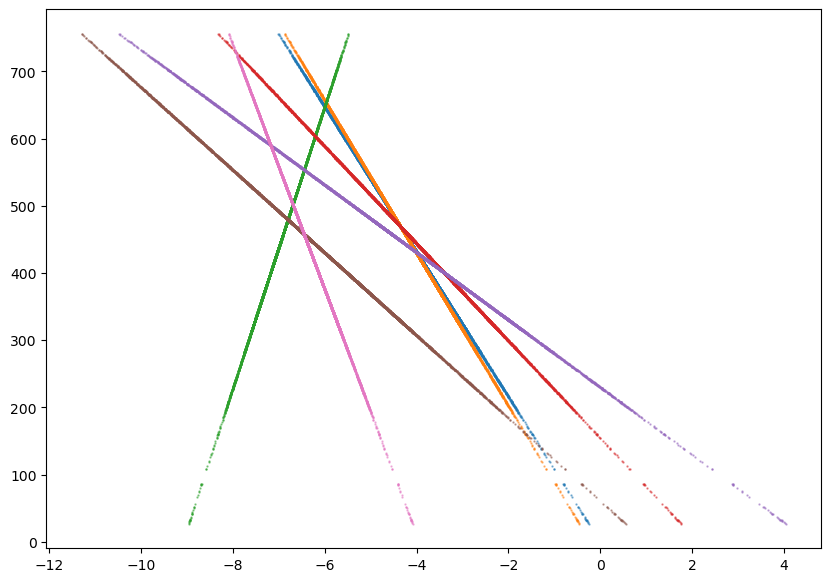

In [149]:
fit_and_plot_ice_shelf_regressions(['Getz'], 
                                   obs23_melt_tm, obs23_draft_tm, 
                                   icems, insar_gl_shape, 
                                   clip_data, find_ice_shelf_index)

In [136]:
import matplotlib.pyplot as plt
import numpy as np

def collect_cumulative_melt_results(
    shelfname, obs23_melt_tm, obs23_draft_tm, icems, insar_gl_shape, 
    clip_data, find_ice_shelf_index, cell_area=3*3*1e6, rho_ice=917
):
    """Collect cumulative melt results for each weighting method for a single shelf."""
    i = find_ice_shelf_index(shelfname)
    mlt = clip_data(obs23_melt_tm, i, icems)
    h = clip_data(obs23_draft_tm, i, icems)
    distances_2d = get_distance_to_gl(mlt, icems, insar_gl_shape)
    weights_dict = get_melt_regression_weights(mlt, h, distances_2d)
    mlt_stack = mlt.stack(z=('x', 'y'))
    h_stack = h.stack(z=('x', 'y'))
    mlt_stack_noNaN = mlt_stack.fillna(0)
    h_stack_noNaN = h_stack.fillna(0)
    mlt_stack_noNaN_vals = mlt_stack_noNaN.values.reshape(-1,1)
    h_stack_noNaN_vals = h_stack_noNaN.values.reshape(-1,1)
    results = {}
    for wname, w2d in weights_dict.items():
        if wname == 'None':
            w = None
        else:
            weights_stack = mlt.copy(data=w2d).stack(z=('x', 'y')).fillna(0)
            w = np.squeeze(weights_stack.values.reshape(-1,1))
        reg = LinearRegression().fit(h_stack_noNaN_vals, mlt_stack_noNaN_vals, sample_weight=w)
        y_pred = reg.predict(h_stack_noNaN_vals).reshape(-1)
        mlt_pred_stack_noNaN = mlt_stack_noNaN.copy(data=y_pred)
        mlt_pred_stack = mlt_pred_stack_noNaN.where(~mlt_stack.isnull(), np.nan)
        mlt_pred = mlt_pred_stack.unstack('z').transpose()
        # Cumulative melt rates
        mlt_is = mlt * cell_area * rho_ice
        mlt_is_cuml = float(mlt_is.sum().values) * 1e-12
        mlt_pred_is = mlt_pred * cell_area * rho_ice
        mlt_pred_is_cuml = float(mlt_pred_is.sum().values) * 1e-12
        results[wname] = (mlt_is_cuml, mlt_pred_is_cuml)
    return results

def plot_cumulative_melt_comparison(results_dict, error_margin=0.3):
    """
    Plot cumulative melt rates and differences for each weighting method.
    Args:
        results_dict: dict {weight_name: (mlt_is_cuml, mlt_pred_is_cuml)}
        error_margin: allowable relative error (e.g., 0.3 for 30%)
    """
    methods = list(results_dict.keys())
    obs = list(results_dict.values())[0][0]  # All have same observed
    preds = [results_dict[m][1] for m in methods]
    diffs = [p - obs for p in preds]
    rel_errs = [abs((p - obs)/obs) if obs != 0 else np.nan for p in preds]
    sign_match = [np.sign(p) == np.sign(obs) for p in preds]

    # Bar plot of cumulative melt
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.axhline(obs, color='k', label='Observed', lw=2)
    for i, m in enumerate(methods):
        color = 'g' if sign_match[i] and rel_errs[i] <= error_margin else 'r'
        plt.bar(m, preds[i], color=color, alpha=0.7)
    plt.ylabel('Cumulative Draft-Dependent Melt (Gt/yr)')
    plt.title('Cumulative Melt by Weighting')
    plt.xticks(rotation=45)
    plt.legend(['Observed'])
    
    # Bar plot of difference
    plt.subplot(1,2,2)
    for i, m in enumerate(methods):
        color = 'g' if sign_match[i] and rel_errs[i] <= error_margin else 'r'
        plt.bar(m, diffs[i], color=color, alpha=0.7)
    plt.axhline(0, color='k', lw=1)
    plt.ylabel('Difference from Observed (Gt/yr)')
    plt.title('Difference from Observed')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print which methods are within margin and correct sign
    print(f"Methods within {int(error_margin*100)}% and correct sign:")
    for m, diff, rel, match in zip(methods, diffs, rel_errs, sign_match):
        if match and rel <= error_margin:
            print(f"  {m}: diff={diff:+.2f} Gt/yr ({rel*100:.1f}% error)")

# Example usage for a single shelf:
# results = collect_cumulative_melt_results(
#     'Amery', obs23_melt_tm, obs23_draft_tm, icems, insar_gl_shape, clip_data, find_ice_shelf_index
# )
# plot_cumulative_melt_comparison(results, error_margin=0.3)

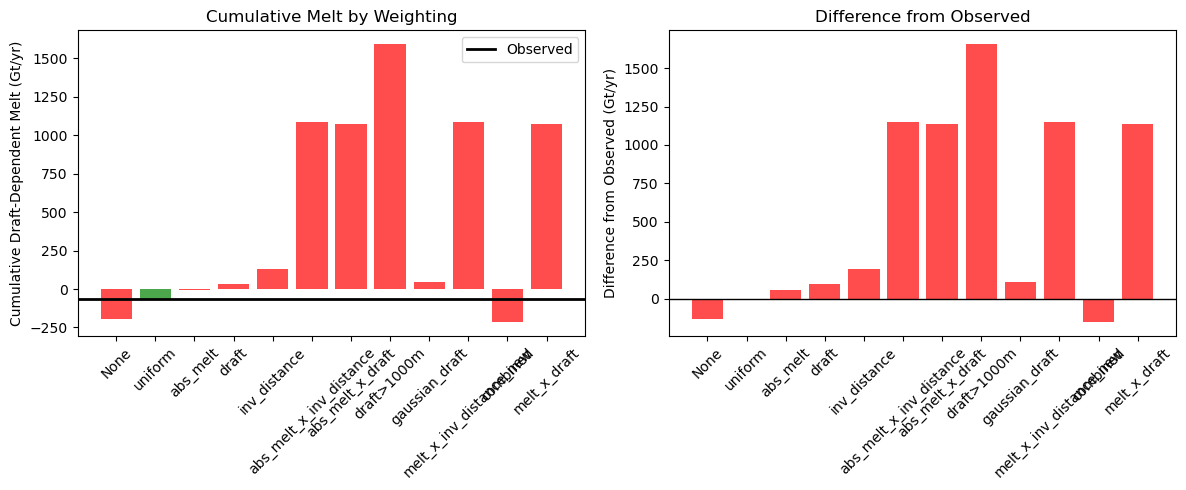

Methods within 30% and correct sign:
  uniform: diff=-0.00 Gt/yr (0.0% error)


In [ ]:
results = collect_cumulative_melt_results('Amery', 
                                          obs23_melt_tm, obs23_draft_tm, 
                                          icems, insar_gl_shape, 
                                          clip_data, find_ice_shelf_index
                                          )


In [139]:
results

{'None': (-63.38985390676779, -196.35189579776),
 'uniform': (-63.38985390676779, -63.38990047232),
 'abs_melt': (-63.38985390676779, -7.693744996352),
 'draft': (-63.38985390676779, 33.002310598656),
 'inv_distance': (-63.38985390676779, 129.818146373632),
 'abs_melt_x_inv_distance': (-63.38985390676779, 1083.1068659712),
 'abs_melt_x_draft': (-63.38985390676779, 1075.232177651712),
 'draft>1000m': (-63.38985390676779, 1591.69541832704),
 'gaussian_draft': (-63.38985390676779, 42.619572846592),
 'melt_x_inv_distance_new': (-63.38985390676779, 1083.1068659712),
 'combined': (-63.38985390676779, -214.02046850662398),
 'melt_x_draft': (-63.38985390676779, 1075.232177651712)}

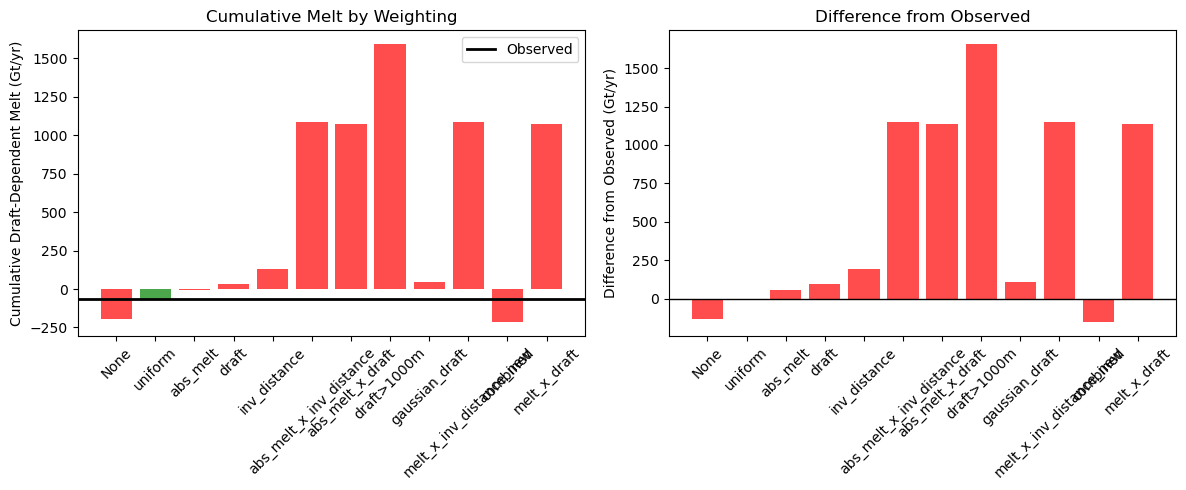

Methods within 80% and correct sign:
  uniform: diff=-0.00 Gt/yr (0.0% error)


In [138]:
plot_cumulative_melt_comparison(results, error_margin=0.8)

In [140]:
import numpy as np
from scipy.signal import savgol_filter

def find_draft_threshold_knee(h, mlt, window=15, poly=2):
    """
    Find the draft threshold where melt rate starts to increase ("knee" point).
    Uses a smoothed median melt vs draft curve and finds the point of max curvature.
    """
    # Flatten and remove NaNs
    hvals = h.values.flatten()
    mvals = mlt.values.flatten()
    mask = ~np.isnan(hvals) & ~np.isnan(mvals)
    hvals = hvals[mask]
    mvals = mvals[mask]
    # Sort by draft (deepest first)
    sort_idx = np.argsort(hvals)
    h_sorted = hvals[sort_idx]
    m_sorted = mvals[sort_idx]
    # Bin drafts for smoothing
    bins = np.linspace(h_sorted.min(), h_sorted.max(), 100)
    digitized = np.digitize(h_sorted, bins)
    bin_medians = np.array([np.median(m_sorted[digitized == i]) for i in range(1, len(bins))])
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    # Smooth the curve
    smoothed = savgol_filter(bin_medians, window_length=min(window, len(bin_medians)//2*2+1), polyorder=poly)
    # Find the "knee" (max 2nd derivative)
    d2 = np.gradient(np.gradient(smoothed))
    knee_idx = np.argmax(d2)
    threshold = bin_centers[knee_idx]
    return threshold

def draft_threshold_weight_dynamic(h, mlt):
    """
    Assign weights of 1 for drafts deeper than the detected threshold, 0 otherwise.
    """
    threshold = find_draft_threshold_knee(h, mlt)
    w = np.where(h.values > threshold, 1.0, 0.0)
    w[np.isnan(h.values)] = np.nan
    return w, threshold

# Example usage inside your regression:
# w, threshold = draft_threshold_weight_dynamic(h, mlt)
# print(f"Dynamic draft threshold for {shelfname}: {threshold:.1f} m")

In [142]:
print(f"Dynamic draft threshold for {shelfname}: {threshold:.1f} m")


Dynamic draft threshold for Filchner-Ronne: 1881.3 m


In [141]:
w, threshold = draft_threshold_weight_dynamic(h, mlt)

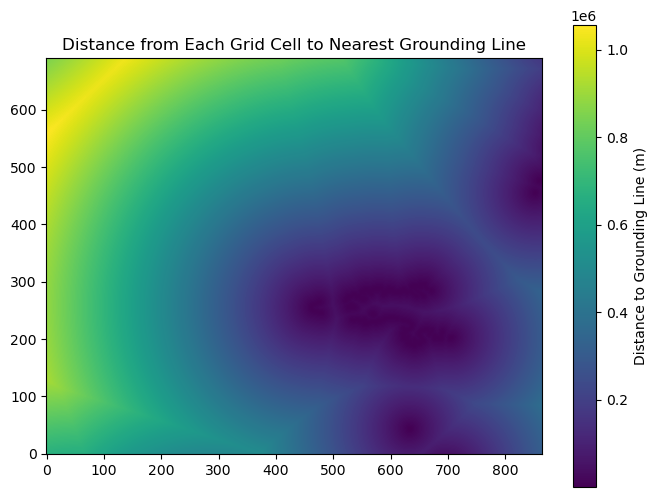

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(distances_2d, origin='lower', cmap='viridis')
plt.colorbar(label='Distance to Grounding Line (m)')
plt.title('Distance from Each Grid Cell to Nearest Grounding Line')
plt.show()

Cumulative melt rate for ice shelf Amery: -63.39 Gt/yr
Cumulative draft-dependent melt rate for ice shelf Amery: -7.69 Gt/yr


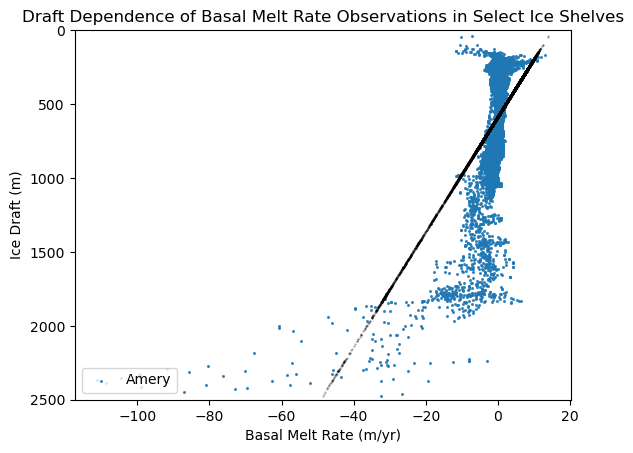

In [78]:
ice_shelves_for_figure = ['Amery', 'Getz', 'Pine_Island', 'Eastern_Ross', 'George_VI', 'Filchner-Ronne']
#ice_shelves_for_figure = ['Filchner-Ronne']
ice_shelves_for_figure = ['Amery']
for shelfname in ice_shelves_for_figure:
    i = find_ice_shelf_index(shelfname)
    # obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.melt

    mlt = clip_data(obs23_melt_tm, i, icems)
    h = clip_data(obs23_draft_tm, i, icems)
    weights = abs(mlt)/abs(mlt).sum()
    # Reshape mlt and h data for linear regression
    mlt_stack = mlt.stack(z=('x', 'y'))#.values.reshape(-1,1)
    h_stack = h.stack(z=('x', 'y'))#.values.reshape(-1,1)
    weights_stack = weights.stack(z=('x', 'y'))

    mlt_stack_noNaN = mlt_stack.fillna(0)
    h_stack_noNaN = h_stack.fillna(0)
    weights_stack_noNaN = weights_stack.fillna(0)

    mlt_stack_noNaN_vals = mlt_stack_noNaN.values.reshape(-1,1)
    h_stack_noNaN_vals = h_stack_noNaN.values.reshape(-1,1)
    weights_stack_noNaN_vals = weights_stack_noNaN.values.reshape(-1,1)

    # X is the independent variable, y is the dependent variable
    # X is the ice draft, y is the melt rate
    X = h_stack_noNaN_vals
    y = mlt_stack_noNaN_vals
    w = np.squeeze(weights_stack_noNaN_vals)
    #w = weights_stack_noNaN_vals.reshape(-1,1)
    # Mask out the values where draft is under 1800 m and then do the regression
    #X = X[mask]
    #y = y[mask]
    #w = w[mask]
    #w = np.squeeze(w)
    reg = LinearRegression().fit(X,y,w)


    # Model predicted value array for melt rate, i.e., the draft dependent component of the melt rate
    y_pred = reg.predict(X)
    mlt_pred_stack_noNaN_vals = y_pred.reshape(-1)
    # Create a new xarray DataArray with the predicted melt rate values
    mlt_pred_stack_noNaN = mlt_stack_noNaN.copy(data=mlt_pred_stack_noNaN_vals)
    # Place NaN values in mlt_pred_stack based on the location of NaN values in mlt_stack
    mlt_pred_stack = mlt_pred_stack_noNaN.where(~mlt_stack.isnull(), np.nan)
    # Reshape the predicted melt rate DataArray to the original shape of the ice shelf
    mlt_pred = mlt_pred_stack.unstack('z').transpose()
    plt.scatter(mlt, h, alpha=0.8, s=1.5, label=shelfname)
    plt.scatter(mlt_pred, h, color='black', alpha=0.4, s=0.2)
    plt.ylim(2500,0)
    mlt_is = mlt*3*3*1e6*917
    mlt_is_cuml = mlt_is.sum()*1e-12
    mlt_pred_is = mlt_pred*3*3*1e6*917
    mlt_pred_is_cuml = mlt_pred_is.sum()*1e-12
    print(f"Cumulative melt rate for ice shelf {icems.name.values[i]}: {mlt_is_cuml:.2f} Gt/yr")
    print(f"Cumulative draft-dependent melt rate for ice shelf {icems.name.values[i]}: {mlt_pred_is_cuml:.2f} Gt/yr")


plt.xlabel('Basal Melt Rate (m/yr)')
plt.ylabel('Ice Draft (m)')
plt.title('Draft Dependence of Basal Melt Rate Observations in Select Ice Shelves')
plt.legend(loc='lower left')


<xarray.DataArray 'melt' ()>
array(-7680.82562786)
Coordinates:
    spatial_ref  int64 0

In [507]:
# Remove mlt_pred from mlt to get the residuals, which we assume as the remaining variability in the melt rate that is not explained by the ice draft

mlt_full = clip_data(obs23_melt_detrend_uniform_deseasonalize_uniform, i)
mlt_full_dedraft = mlt_full - mlt_pred

mlt_full_ts = mlt_full.mean(dim=['x', 'y']).compute()
mlt_full_dedraft_ts = mlt_full_dedraft.mean(dim=['x', 'y']).compute()

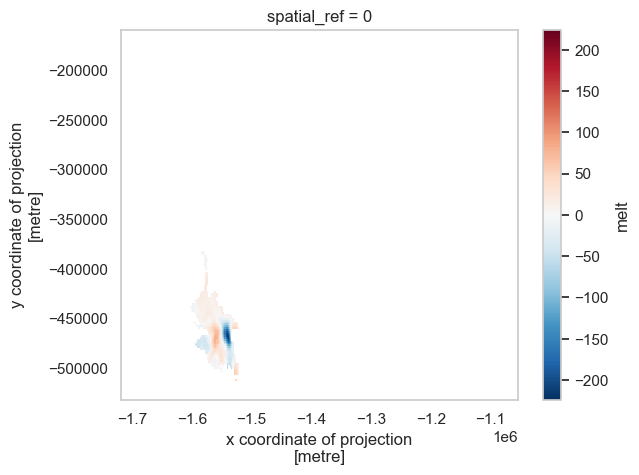

In [508]:
mlt_full_dedraft_tm = mlt_full_dedraft.mean(dim='time').compute()
mlt_full_dedraft_tm.plot()

In [509]:
#climfit = obs23_melt_detrend_uniform_ts - obs23_melt_detrend_uniform_deseasonalize_uniform_ts
obs23_melt_detrend_uniform.rio.write_crs("epsg:3031",inplace=True);
mlt_detrend = clip_data(obs23_melt_detrend_uniform, i)
mlt_detrend_deseasonalize = clip_data(obs23_melt_detrend_uniform_deseasonalize_uniform, i)
mlt_detrend_ts = mlt_detrend.mean(dim=['x', 'y']).compute()
mlt_detrend_deseasonalize_ts = mlt_detrend_deseasonalize.mean(dim=['x', 'y']).compute()
mlt_clim = mlt_detrend_ts - mlt_full_ts

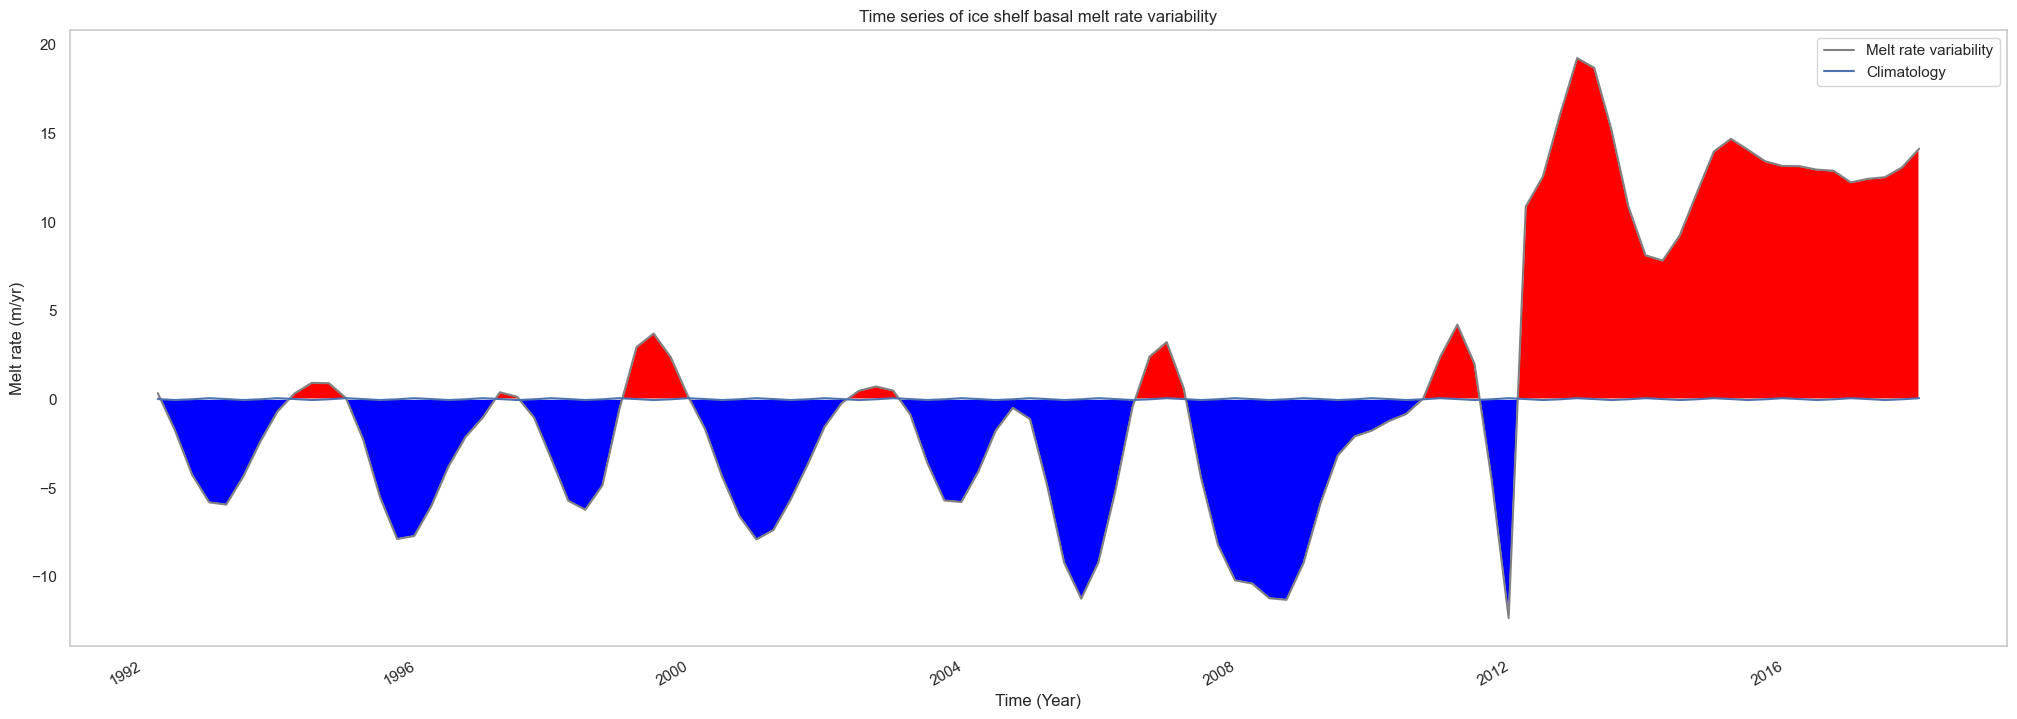

ERROR:tornado.application:Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 52 MB fds: 337>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/system_monitor.py", line 134, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory
2024-05-01 20:43:40,420 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 0 memory: 52 MB fds: 337>>
Traceback (most recent call last):
  File "/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/tornado/ioloop.

In [510]:
# Plot the time series of the melt rate variability at the deepest point in the ice shelf
plt.figure(figsize=(25,8))
#mlt_full_ts.plot(label='Total melt rate variability')
#obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(label='Deseasonalized melt rate')
#obs23_melt_ts.plot(label='Raw melt rate')
#climfit.plot(label='Climatology')
mlt_full_dedraft_ts.plot(color='grey', label='Melt rate variability')
# mlt_detrend_ts.plot(label='Detrended melt rate')
(mlt_clim).plot(label='Climatology')
#plt.axhline(0, color='black', lw=1.5)
plt.title('Time series of ice shelf basal melt rate variability')

# Fill positive values in the melt rate variability with red color and negative values with blue color
# Fill space between the two curves with a light grey color
plt.fill_between(mlt_full_dedraft_ts.time.values, 0, mlt_full_dedraft_ts, where=mlt_full_dedraft_ts >= 0, facecolor='red', interpolate=True)
plt.fill_between(mlt_full_dedraft_ts.time.values, 0, mlt_full_dedraft_ts, where=mlt_full_dedraft_ts <= 0, facecolor='blue', interpolate=True)

plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.legend()
plt.grid()

In [ ]:
# Plot the time series of the melt rate variability at the deepest point in the ice shelf
plt.figure(figsize=(25,8))
#mlt_full_ts.plot(label='Total melt rate variability')
#obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(label='Deseasonalized melt rate')
#obs23_melt_ts.plot(label='Raw melt rate')
#climfit.plot(label='Climatology')
mlt_full_dedraft_ts.plot(color='grey', label='Melt rate variability')
# mlt_detrend_ts.plot(label='Detrended melt rate')
(mlt_clim+climfit).plot(label='Climatology')
#plt.axhline(0, color='black', lw=1.5)
plt.title('Time series of ice shelf basal melt rate variability')

# Fill positive values in the melt rate variability with red color and negative values with blue color
# Fill space between the two curves with a light grey color
plt.fill_between(mlt_full_dedraft_ts.time.values, 0, mlt_full_dedraft_ts, where=mlt_full_dedraft_ts >= 0, facecolor='red', interpolate=True)
plt.fill_between(mlt_full_dedraft_ts.time.values, 0, mlt_full_dedraft_ts, where=mlt_full_dedraft_ts <= 0, facecolor='blue', interpolate=True)

plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.legend()
plt.grid()


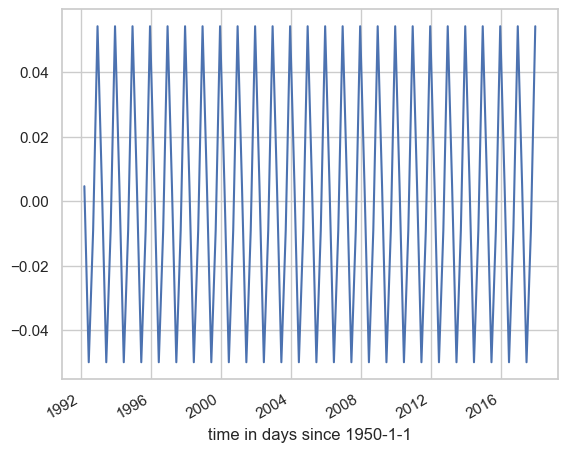

In [474]:
(climfit).plot(label='Climatology')

In [420]:
mlt_pred = xr.DataArray(mlt_pred, coords=mlt.coords, dims=mlt.dims)


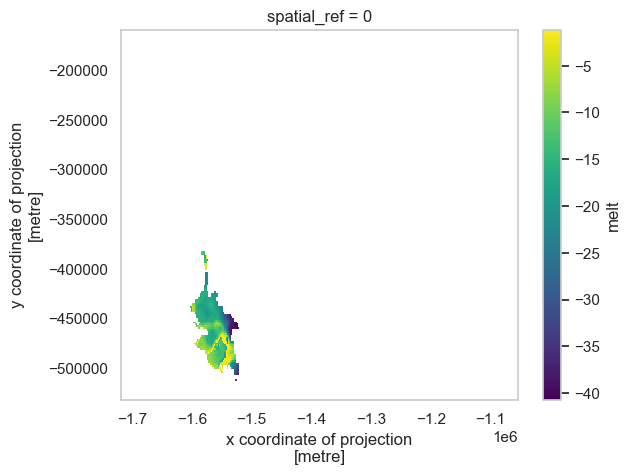

In [421]:
mlt_pred.plot()


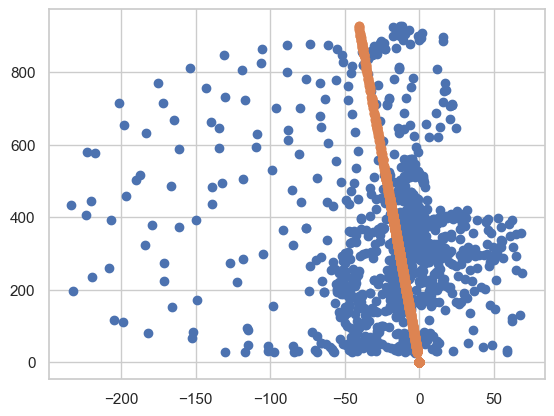

In [422]:
plt.scatter(mlt, h)
plt.scatter(reg.predict(X), X)

In [149]:
model = LinearRegression().fit(mlt_stack_noNaN_vals,h_stack_noNaN_vals)

## Alternate method
### 1. Detrend: Linear (uniform at all spatial points) 
### 2. Clip data to ice shelf
###     2.1. Deseasonalize (for each ice shelf)
###     2.2. Dedraft (for each ice shelf)



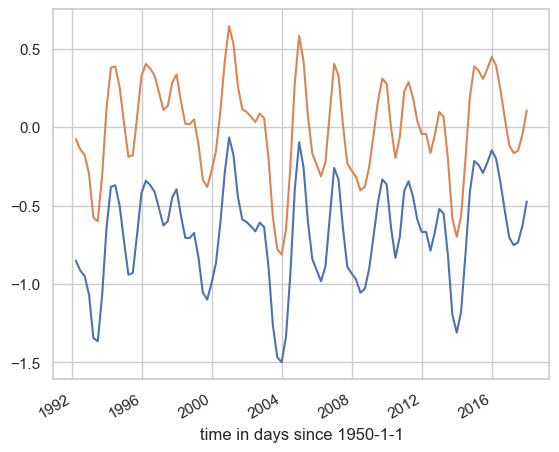

In [428]:
obs23_melt_ts.plot()
obs23_melt_detrend_uniform_ts.plot()


In [430]:
obs23_melt_detrend_uniform_tm = obs23_melt_detrend_uniform.mean(dim='time').compute()

In [441]:
# A function that removes climatologies to isolate anomalies / deseasonalize
def deseasonalize(data):
    data_month = data.groupby("time.month")
    data_clm = data_month.mean("time") # Climatologies
    data_anm = data_month - data_clm # Deseasonalized anomalies
    return data_anm

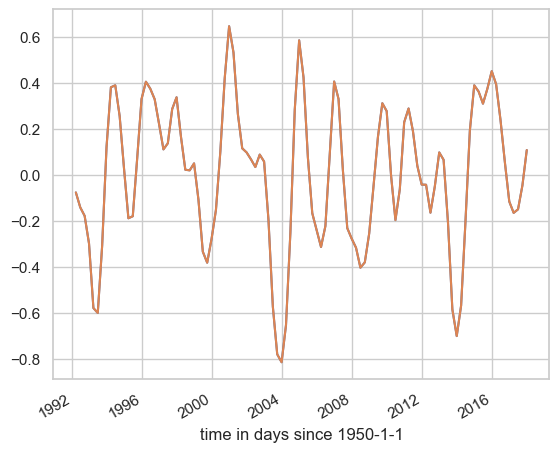

In [ ]:
# Deseasonalize with a uniform/average climatology

mlt_detrend_uniform_deseasonalize_uniform_ts = deseasonalize(mlt_detrend_uniform_ts)


climfit = obs23_melt_detrend_uniform_ts - mlt_detrend_uniform_deseasonalize_uniform_ts
obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform - climfit

In [431]:
mlt_detrend = clip_data(obs23_melt_detrend_uniform, i)

# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize
mlt_detrend_month = mlt_detrend.groupby("time.month")
mlt_detrend_clm = mlt_detrend_month.mean("time").compute() # Climatologies
mlt_detrend_anm = (mlt_detrend_month - mlt_detrend_clm).compute() # Deseasonalized anomalies



In [437]:
mlt_detrend_ts = mlt_detrend.mean(dim=['x', 'y']).compute()

In [439]:
mlt_detrend_clm_ts = mlt_detrend_ts - mlt_detrend_anm_ts

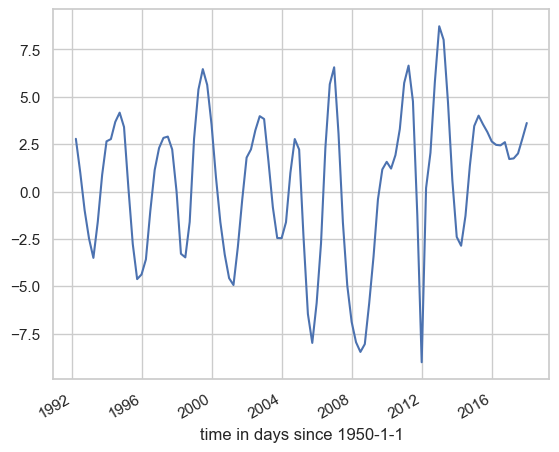

In [433]:
mlt_detrend_anm_ts = mlt_detrend_anm.mean(['x', 'y']).compute()
mlt_detrend_anm_ts.plot()

In [ ]:
i = 114
# obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.melt

mlt = clip_data(obs23_melt_detrend_uniform_tm, i)
h = clip_data(obs23_draft_tm, i)

# Reshape mlt and h data for linear regression
mlt_stack = mlt.stack(z=('x', 'y'))#.values.reshape(-1,1)
h_stack = h.stack(z=('x', 'y'))#.values.reshape(-1,1)

mlt_stack_noNaN = mlt_stack.fillna(0)
h_stack_noNaN = h_stack.fillna(0)

mlt_stack_noNaN_vals = mlt_stack_noNaN.values.reshape(-1,1)
h_stack_noNaN_vals = h_stack_noNaN.values.reshape(-1,1)

# X is the independent variable, y is the dependent variable
# X is the ice draft, y is the melt rate
X = h_stack_noNaN_vals
y = mlt_stack_noNaN_vals
reg = LinearRegression().fit(X,y)
print("X is:")
print(X)
print("Shape of X is: {}".format(X.shape))
print("Coefficient (slope) is: ")
print(reg.coef_)
print("Intercept is: ")
print(reg.intercept_)
print("y is:")
print(y)
#print("Predicted y for X = [3,5] is:")
#print(reg.predict(np.array([[3,5]])))

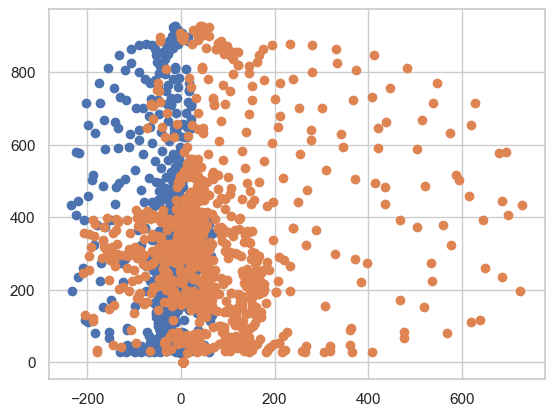

In [152]:
plt.scatter(mlt,h)
plt.scatter(model.predict(mlt_stack_noNaN_vals),h_stack_noNaN_vals)

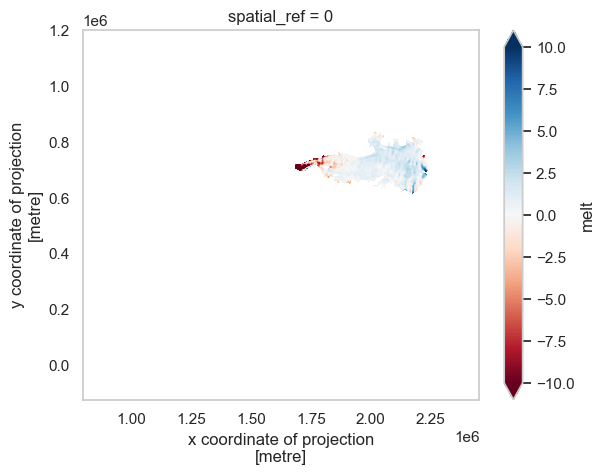

In [113]:
mlt.plot(vmin=-10, vmax=10, cmap='RdBu')

In [50]:
# Reshape the data to a 2D array in space and time to perform a linear regression
X = mlt.stack(z=('x', 'y')).values
X = X.transpose()
# y = h.values.reshape(-1,1)
y = h.stack(z=('x', 'y')).values
y = y.transpose()
#y = h.mean('time').values.reshape(-1,1)

In [55]:
X = mlt.values.reshape(-1,1)
y = h.values.reshape(-1,1)

In [88]:
X = h.mean('time').stack(z=('x', 'y')).values.reshape(-1,1)
y = mlt.mean('time').stack(z=('x', 'y')).values.reshape(-1,1)

model = LinearRegression().fit(X,y)

In [57]:
X = X.fillna(0)
#h = h.fillna(0)

AttributeError: 'numpy.ndarray' object has no attribute 'fillna'

In [58]:
model = LinearRegression().fit(np.nan_to_num(y),np.nan_to_num(X))

In [59]:
coeffs = model.coef_
intercept = model.intercept_

(194, 346)

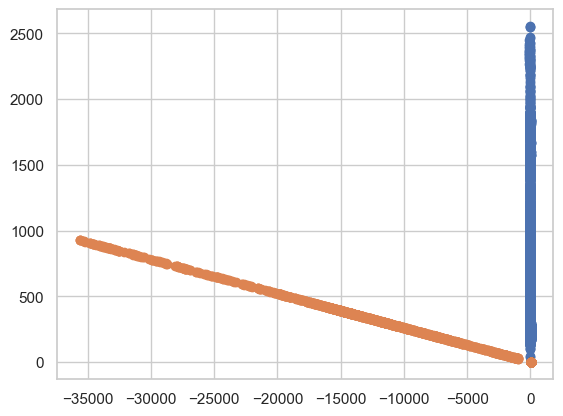

In [145]:
plt.scatter(mlt,h)
plt.scatter(model.predict(np.nan_to_num(y)),np.nan_to_num(y))

In [65]:
# mlt_dedraft = mlt - model.predict(X).reshape(h_tm.shape)

mlt_dedraft = mlt - model.predict(np.nan_to_num(X)).reshape(h.shape)

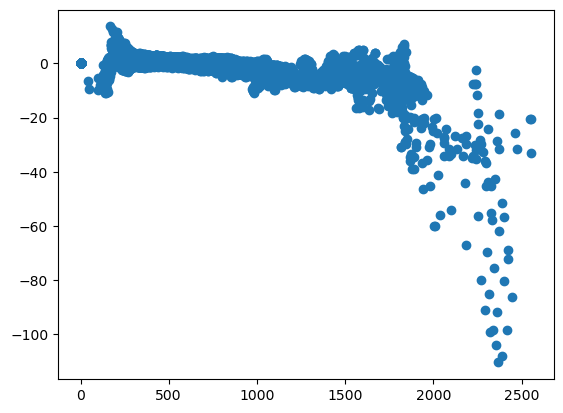

In [74]:
plt.scatter(h.values.reshape(-1),mlt_tm.values.reshape(-1))

In [18]:
def xr_regression(y):
    X = sm.add_constant(mlt_tm, prepend=True) # regressor matrix
    mod = sm.GLSAR(y.values, X, 2, missing = 'drop') # MLR analysis with AR2 modeling
    res = mod.iterative_fit()
    return xr.DataArray(res.params[1:])

In [ ]:
stacked = anomalies.stack(allpoints = ['lev', 'lat']).squeeze()
stacked = stacked.reset_coords(drop=True)
coefs = stacked.groupby('allpoints').apply(xr_regression)
coefs_unstacked = coefs.unstack('allpoints')

In [ ]:

# Dedraft: Linear Regression with SSH over chosen basin
print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
mlt_rgrs = xr_linregress(h, mlt_tm) # h = independent variable
# Save the parameters/co-efficients of the linear regression function for each ice shelf as a NETCDF file
#mlt_rgrs.to_netcdf(main_dir / DIR_interim / 'dedraft/iceShelfRegions/{}_DEDRAFT_PARAMS.nc'.format(icems.name.values[i]))
#mlt_prd = mlt_rgrs.slope*SORRMv21_DRAFT_TMEAN + mlt_rgrs.intercept

In [ ]:
for i in iceShelfRegions:
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mlt = SORRMv21_DETREND_DESEASONALIZE_FLUX.rio.clip(icems.loc[[i],'geometry'].apply(mapping),icems.crs,drop=False)
    # mlt = MELTDRAFT_OBS.melt.rio.clip(icems.loc[[i],'geometry'].apply(mapping),icems.crs,drop=False)
    mlt_mean = mlt.mean(tdim)
    # Dedraft: Linear Regression with SSH over chosen basin
    print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
    mlt_rgrs = xr_linregress(SORRMv21_DRAFT, mlt_mean, dim=tdim) # h = independent variable
    # Save the parameters/co-efficients of the linear regression function for each ice shelf as a NETCDF file
    mlt_rgrs.to_netcdf(main_dir / DIR_interim / 'dedraft/iceShelfRegions/{}_DEDRAFT_PARAMS.nc'.format(icems.name.values[i]))
    mlt_prd = mlt_rgrs.slope*SORRMv21_DRAFT_TMEAN + mlt_rgrs.intercept
    # flx_ddrft = flx - flx_prd
    # Save the linear regression function fit of the melt flux over each ice shelf as a NETCDF file
    # The dedrafted melt flux is calculated as the difference between the actual melt flux and the predicted melt flux, done in the next merge_dedraft_data.py step.
    mlt_prd.to_netcdf(main_dir / DIR_interim / 'dedraft/iceShelfRegions/{}_DEDRAFT_REGRESS.nc'.format(icems.name.values[i]))
    print('{} file saved'.format(icems.name.values[i]))
    del mlt, mlt_mean, mlt_rgrs, mlt_prd
    print('deleted interim variables')
    gc.collect()

In [88]:
IMBIEregions = range(6,33)
iceShelfRegions = range(33,133)

iceShelfRegions = range(6,16)

for i in iceShelfRegions:
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mltanm = clip_data(obs23_melt_tm, i)
    z = clip_data(obs23_draft_tm, i)
    plt.scatter(mltanm, z, marker='x', s=3)
    plt.ylim(2500,0)
    del mltanm, z
    print('deleted interim variables')
    gc.collect()

extracting data for catchment IMBIE1


MissingCRS: CRS not found. Please set the CRS with 'rio.write_crs()'. Data variable: melt

In [ ]:
# will need to use relative drafts here?